## Wikidata Items' ORES score analysis
```
As a user, if there is catastrophic Wikidata loss, I want to keep items with (good) ORES scores, as they may be more useful to me in querying.

- How many items do not have ORES scores?
- What is the distribution of ORES scores for Wikidata items?
- Is there an optimal separation between high/low ORES scores?
- If so, what is it?
```
Phab: [T288262](https://phabricator.wikimedia.org/T288262)

# Import and Set up Spark

In [1]:
import wmfdata
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import numpy as np
import pandas as pd
from statistics import mean
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
from  matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display, clear_output

You are using wmfdata v1.2, but v1.3.1 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md


In [ ]:
spark = wmfdata.spark.get_session(type='yarn-large', app_name="wdqs-analysis", 
                                  extra_settings={
                                             "spark.driver.memory": "16g",
                                            "spark.executor.memory": "16g",
                                            "spark.sql.shuffle.partitions": 1024
                                  },
                                 )

In [3]:
from pyspark.sql.functions import explode, col
import pyspark.sql.functions as F

# Utils

In [4]:
## WIKIDATA
date = "20220103"
from_clause = f"from discovery.wikibase_rdf where date={date} and wiki='wikidata'"

wd = 'http://www.wikidata.org/entity/'
wdt = 'http://www.wikidata.org/prop/direct/'
p31 = wdt+'P31'

## SPARQL
date = [2021,12,31,0] # year, month, day, hour

h_clause = f"year={date[0]} and month={date[1]} and day={date[2]} and hour={date[3]}"
d_clause = f"year={date[0]} and month={date[1]} and day={date[2]}"
m_clause = f"year={date[0]} and month={date[1]}"

from_sparql = f"from discovery.processed_external_sparql_query where {h_clause} and wiki='wikidata'"
from_sparql_d = f"from discovery.processed_external_sparql_query where {d_clause} and wiki='wikidata'"
from_sparql_m = f"from discovery.processed_external_sparql_query where {m_clause} and wiki='wikidata'"

event_wdqs = "event.wdqs_external_sparql_query"

## SPARK UTILS
pred2codeUDF = F.udf(lambda x: x.split('/')[-1][:-1]) ## from <http://wikidata.org/prop/direct/P90> to P90

## ORES

ores_table = 'event.mediawiki_revision_score'

from_ores = f"from {ores_table} where {h_clause} and database = 'wikidatawiki'"
from_ores_d = f"from {ores_table} where {d_clause} and database = 'wikidatawiki'"
from_ores_m = f"from {ores_table} where {m_clause} and database = 'wikidatawiki'"
from_ores_all = f"from {ores_table} where database = 'wikidatawiki'"

ores_sanitized_table = 'event_sanitized.mediawiki_revision_score'

from_ores_sanitized = f"from {ores_sanitized_table} where {h_clause} and database = 'wikidatawiki'"
from_ores_sanitized_d = f"from {ores_sanitized_table} where {d_clause} and database = 'wikidatawiki'"
from_ores_sanitized_m = f"from {ores_sanitized_table} where {m_clause} and database = 'wikidatawiki'"
from_ores_sanitized_all = f"from {ores_sanitized_table} where database = 'wikidatawiki'"

In [5]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

def get_results(query, col_list):
    endpoint_url = "https://query.wikidata.org/sparql"
    user_agent = "akhatun-ctr-wdqs"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    results = pd.json_normalize(results['results']['bindings'])
    
    if len(results)==0:
        return "Empty Df"
        
    col_list_value = [col+".value" for col in col_list]
    col_map = {col+".value":col for col in col_list}
    return results[col_list_value].rename(columns = col_map)

In [6]:
def df2wikitable(df):
    for _,row in df.iterrows():
        ls = [str(l) for l in row]
        s = '|-\n|' + '||'.join(ls)
        print(s)

# Total triples

In [7]:
WD = spark.sql(f"""select * {from_clause}""")

In [8]:
total_triples = WD.count()
total_triples

13542455182

In [8]:
total_triples = 13542455182 # 2022/1/03 
# 13434021950 ## 2021/11/29
# 13208971680 ## 2021/11/01

# Explores ORES table

- [x] https://ores.wikimedia.org/ : This has the API end points and a UI as well
- [x] **ORES DOCS**: https://www.mediawiki.org/wiki/ORES
    - FAQ: https://www.mediawiki.org/wiki/ORES/FAQ
    - Background and basics on Wikipedia: https://diff.wikimedia.org/2015/11/30/artificial-intelligence-x-ray-specs/
- [x] **ORES WD**: https://www.wikidata.org/wiki/Wikidata:ORES
     - Add `==Subpages==
    {{Special:PrefixIndex/{{FULLPAGENAME}}/ |hideredirects=1 |stripprefix=1}}` at the end of this page to see subpages
        - **Features**: https://www.wikidata.org/wiki/Wikidata:ORES/List_of_features
        - **Usage**: https://www.wikidata.org/wiki/Wikidata:ORES/Usage
     - **WD Item Quality:** https://www.wikidata.org/wiki/Wikidata:Item_quality
     - Example: https://ores.wikimedia.org/v3/scores/wikidatawiki/247205553
     - Blog: https://blog.wikimedia.de/2016/01/02/teaching-machines-to-make-your-life-easier-quality-work-on-wikidata/
          - Results phab: https://phabricator.wikimedia.org/T122687
          - ML page: https://www.mediawiki.org/wiki/Machine_Learning
- Get WD item quality: https://item-quality-evaluator.toolforge.org/
    - https://github.com/wmde/wikidata-item-quality-evaluator
- DataLake: https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/ORES
    
## Types of predictions:
- `reverted` – predicts whether an edit will eventually be reverted
- `damaging` – predicts if an edit causes damage
- `goodfaith` – predicts whether an edit was saved in good-faith
- `draftquality` – predicts if the article will need to be speedy deleted (spam, vandalism, attack, or OK)
- `articlequality`– predicts the (Wikipedia 1.0-like) assessment class of an article or draft.
    We can automatically assess every article and every revision with a computer. The articlequality model bases its predictions on structural characteristics of the article. E.g. How many sections are there? Is there an infobox? How many references? And do the references use a {{cite}} template? The articlequality model doesn't evaluate the quality of the writing or if there's a tone problem (e.g. a point of view being pushed). However, many of the structural characteristics of articles seem to correlate strongly with good writing and tone, so the models work very well in practice.
- `drafttopic` – predicts the topic of an a new article draft
- `articletopic` – predicts the topic of an article. [more details](https://www.mediawiki.org/wiki/ORES/Articletopic)


## Necessary docs:
- [x] **ORES DOCS**: https://www.mediawiki.org/wiki/ORES
- [x] **WD Item Quality:** https://www.wikidata.org/wiki/Wikidata:Item_quality
- Get WD item quality: https://item-quality-evaluator.toolforge.org/
- DataLake: https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/ORES
- Schema: https://github.com/wikimedia/mediawiki-event-schemas/blob/master/jsonschema/mediawiki/revision/score/2.0.0.yaml

# ORES TABLE

In [9]:
spark.table(ores_table).printSchema()

root
 |-- _schema: string (nullable = true)
 |-- meta: struct (nullable = true)
 |    |-- uri: string (nullable = true)
 |    |-- request_id: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- dt: string (nullable = true)
 |    |-- domain: string (nullable = true)
 |    |-- stream: string (nullable = true)
 |-- database: string (nullable = true)
 |-- performer: struct (nullable = true)
 |    |-- user_id: long (nullable = true)
 |    |-- user_text: string (nullable = true)
 |    |-- user_groups: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- user_is_bot: boolean (nullable = true)
 |    |-- user_registration_dt: string (nullable = true)
 |    |-- user_edit_count: long (nullable = true)
 |-- page_id: long (nullable = true)
 |-- page_title: string (nullable = true)
 |-- page_namespace: long (nullable = true)
 |-- page_is_redirect: boolean (nullable = true)
 |-- rev_id: long (nullable = true)
 |-- rev_parent_id: long (nullable =

In [19]:
spark.sql(f"SELECT COUNT(DISTINCT database) from {ores_table}").show(truncate=False)

[Stage 13:>                                                         (0 + 1) / 1]

+------------------------+
|count(DISTINCT database)|
+------------------------+
|45                      |
+------------------------+



In [20]:
spark.sql(f"SELECT DISTINCT database from {ores_table}").show(50, truncate=False)

[Stage 25:=====================================================>(397 + 2) / 399]

+------------+
|database    |
+------------+
|eswikiquote |
|hywiki      |
|enwiktionary|
|ukwiki      |
|glwiki      |
|svwiki      |
|cswiki      |
|srwiki      |
|fawiki      |
|ruwiki      |
|tawiki      |
|huwiki      |
|viwiki      |
|itwiki      |
|ptwiki      |
|fiwiki      |
|trwiki      |
|lvwiki      |
|nowiki      |
|elwiki      |
|idwiki      |
|frwiki      |
|iswiki      |
|bswiki      |
|wikidatawiki|
|jawiki      |
|hewiki      |
|simplewiki  |
|etwiki      |
|nlwiki      |
|arwiki      |
|eswiki      |
|dewiki      |
|sqwiki      |
|bnwiki      |
|hrwiki      |
|testwiki    |
|zhwiki      |
|rowiki      |
|euwiki      |
|plwiki      |
|kowiki      |
|cawiki      |
|enwiki      |
|frwikisource|
+------------+



In [17]:
ores_table, from_ores

('event.mediawiki_revision_score',
 "from event.mediawiki_revision_score where year=2021 and month=12 and day=31 and hour=0 and database = 'wikidatawiki'")

In [25]:
spark.sql(f"select COUNT(*) {from_ores}").show(truncate=False)

+--------+
|count(1)|
+--------+
|35216   |
+--------+



In [22]:
spark.sql(f"select COUNT(DISTINCT page_namespace) {from_ores}").show(truncate=False)

[Stage 29:==============================================>      (903 + 5) / 1024]

+------------------------------+
|count(DISTINCT page_namespace)|
+------------------------------+
|9                             |
+------------------------------+



In [23]:
spark.sql(f"select COUNT(DISTINCT page_id) {from_ores}").show(truncate=False)

[Stage 32:========================================>           (793 + 12) / 1024]

+-----------------------+
|count(DISTINCT page_id)|
+-----------------------+
|24678                  |
+-----------------------+



In [24]:
spark.sql(f"select COUNT(DISTINCT page_title) {from_ores}").show(truncate=False)

[Stage 35:==========================================>         (844 + 16) / 1024]

+--------------------------+
|count(DISTINCT page_title)|
+--------------------------+
|24678                     |
+--------------------------+



In [26]:
spark.sql(f"select COUNT(DISTINCT page_id, page_title) {from_ores}").show(truncate=False)

[Stage 40:==================================================> (995 + 16) / 1024]

+-----------------------------------+
|count(DISTINCT page_id, page_title)|
+-----------------------------------+
|24678                              |
+-----------------------------------+



In [27]:
spark.sql(f"select DISTINCT normalized_host.project_class {from_ores}").show(truncate=False)

+-------------+
|project_class|
+-------------+
|wikidata     |
+-------------+



In [28]:
spark.sql(f"select DISTINCT normalized_host.project_family {from_ores}").show(truncate=False)

+--------------+
|project_family|
+--------------+
|wikidata      |
+--------------+



In [49]:
spark.sql(f"select COUNT(DISTINCT meta.id) {from_ores}").show(truncate=False)

[Stage 268:=================================================>  (972 + 4) / 1024]

+-------------------------------+
|count(DISTINCT meta.id AS `id`)|
+-------------------------------+
|35216                          |
+-------------------------------+



In [50]:
spark.sql(f"select COUNT(DISTINCT meta.request_id) {from_ores}").show(truncate=False)

[Stage 271:=================================================> (988 + 20) / 1024]

+-----------------------------------------------+
|count(DISTINCT meta.request_id AS `request_id`)|
+-----------------------------------------------+
|35182                                          |
+-----------------------------------------------+



In [73]:
spark.sql(f"select COUNT(DISTINCT rev_id) {from_ores}").show(truncate=False)

[Stage 325:==================================================>(1005 + 4) / 1024]

+----------------------+
|count(DISTINCT rev_id)|
+----------------------+
|35215                 |
+----------------------+



In [74]:
## what rev_id occurs more than once?
spark.sql(f"select * {from_ores}").groupby("rev_id").count().filter("count > 1").show(truncate=False)

+----------+-----+
|rev_id    |count|
+----------+-----+
|1553001809|2    |
+----------+-----+



In [76]:
spark.sql(f"select * {from_ores}").filter("rev_id == 1553001809").show(truncate=False, vertical=True)

[Stage 343:============================>                            (2 + 2) / 4]

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [55]:
spark.sql(f"select meta.id, meta.request_id {from_ores}")

DataFrame[id: string, request_id: string]

In [58]:
spark.sql(f"select meta.id, meta.request_id {from_ores}").groupby("id")\
    .agg(F.count("request_id").alias("request_id_count"))\
    .sort("request_id_count", ascending=False).show(truncate=False)

#    .filter("request_id_count > 1")\

[Stage 290:==============================>                    (622 + 16) / 1024]

+------------------------------------+----------------+
|id                                  |request_id_count|
+------------------------------------+----------------+
|3ce414d0-69cf-11ec-90b3-adba405186db|1               |
|76343610-69d0-11ec-90b3-adba405186db|1               |
|31920880-69d4-11ec-90b3-adba405186db|1               |
|a2534b70-69ce-11ec-90b3-adba405186db|1               |
|bcc51aa0-69d4-11ec-90b3-adba405186db|1               |
|9dde81a0-69cd-11ec-90b3-adba405186db|1               |
|6e3ebbe0-69cd-11ec-90b3-adba405186db|1               |
|6f9367b0-69d3-11ec-90b3-adba405186db|1               |
|793b85d0-69d4-11ec-90b3-adba405186db|1               |
|7f16a850-69d3-11ec-90b3-adba405186db|1               |
|fa7952f0-69cd-11ec-90b3-adba405186db|1               |
|63925380-69d4-11ec-90b3-adba405186db|1               |
|9be03940-69d0-11ec-90b3-adba405186db|1               |
|804205c0-69cf-11ec-90b3-adba405186db|1               |
|bf227d80-69d2-11ec-90b3-adba405186db|1         

In [21]:
spark.sql(f"select * {from_ores}").show(1, truncate=False, vertical=True)

[Stage 27:=============================>                            (2 + 2) / 4]

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [38]:
spark.sql(f"select * {from_ores}").select(F.explode("scores")).select("key", "value.*").show(5, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
## Explore: Keys, Models Names, Model Versions

df = spark.sql(f"select * {from_ores}").select(F.explode("scores")).select("key", "value.*")
df.select("key").distinct().show(5, truncate=False)
df.select("model_name").distinct().show(5, truncate=False)

print("DISTINCT model name, model versions COUNT:", 
      df.select("model_name", "model_version").distinct().count())
## VERSIONS PER MODEL
df.groupby("model_name").agg(F.countDistinct("model_version")).show(50, truncate=False)
df.select("model_name", "model_version").distinct().show(5, truncate=False)

+-----------+
|key        |
+-----------+
|goodfaith  |
|itemtopic  |
|itemquality|
|damaging   |
+-----------+



+-----------+
|model_name |
+-----------+
|goodfaith  |
|itemtopic  |
|itemquality|
|damaging   |
+-----------+



DISTINCT model name, model versions COUNT: 4


+-----------+-----------------------------+
|model_name |count(DISTINCT model_version)|
+-----------+-----------------------------+
|goodfaith  |1                            |
|itemtopic  |1                            |
|itemquality|1                            |
|damaging   |1                            |
+-----------+-----------------------------+



+-----------+-------------+
|model_name |model_version|
+-----------+-------------+
|itemquality|0.5.0        |
|goodfaith  |0.5.0        |
|damaging   |0.5.0        |
|itemtopic  |1.2.0        |
+-----------+-------------+



**Data To Use**
- meta
    - uri  | https://www.wikidata.org/wiki/Q865920
    - request_id | 6faa2880-4b2d-4ce4-9df1-09f21d1ee5c1 ??
    - id: string | c4147550-69cd-11ec-90b3-adba405186db ??
- page_namespace   | 0 ??
- page_title       | Q865920
- page_id          | 817276 ??
- rev_id          | 1552974521
- rev_parent_id    | 1315288970
- rev_timestamp    | 2021-12-31T00:08:20Z
- scores (k/v)
    - model_name    | damaging
    - model_version | 0.5.0
    - prediction    | [false]
    - probability   | [false -> 0.9381482136786469, true -> 0.061851786321353165]
    
    
---
- request_id: Unique ID of the request that caused the event
- id: Unique ID of this event
- user_id: The user id that performed this change. This is optional, and will not be present for anonymous users.
- user_text: The text representation of the user that performed this change. Always present.

In [79]:
print("Hourly:", spark.sql(f"select * {from_ores}").count())
print("Daily:", spark.sql(f"select * {from_ores_d}").count())
print("Monthly:", spark.sql(f"select * {from_ores_m}").count())
print("All:", spark.sql(f"select * {from_ores_all}").count())

Hourly: 35216


Daily: 736920


Monthly: 16887657


[Stage 352:>                                                        (0 + 1) / 1]

All: 49313300


In [16]:
ores_df = spark.sql(f"""select meta.id, page_title, 
                        rev_id, rev_parent_id, rev_timestamp, scores {from_ores_all}""")

exploded_ores_df = ores_df.select("*", F.explode("scores")).select("*", "value.*")\
                          .drop("scores", "key", "value")

ores_df.printSchema(), exploded_ores_df.printSchema();

root
 |-- id: string (nullable = true)
 |-- page_title: string (nullable = true)
 |-- rev_id: long (nullable = true)
 |-- rev_parent_id: long (nullable = true)
 |-- rev_timestamp: string (nullable = true)
 |-- scores: map (nullable = true)
 |    |-- key: string
 |    |-- value: struct (valueContainsNull = true)
 |    |    |-- model_name: string (nullable = true)
 |    |    |-- model_version: string (nullable = true)
 |    |    |-- prediction: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- probability: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: double (valueContainsNull = true)

root
 |-- id: string (nullable = true)
 |-- page_title: string (nullable = true)
 |-- rev_id: long (nullable = true)
 |-- rev_parent_id: long (nullable = true)
 |-- rev_timestamp: string (nullable = true)
 |-- model_name: string (nullable = true)
 |-- model_version: string (nullable = true)
 |-- prediction: array (nullable = 

In [11]:
exploded_ores_df.cache()

DataFrame[id: string, page_title: string, rev_id: bigint, rev_parent_id: bigint, rev_timestamp: string, model_name: string, model_version: string, prediction: array<string>, probability: map<string,double>]

In [12]:
ores_df.count(), exploded_ores_df.count()

(49375299, 154419203)

In [84]:
154580360/49398406 ## predictions per revision

3.1292580574361044

In [71]:
## How many items/Q-Items do we have??

Wikidata Datatypes (apparantly its only for porperties): 
`During creation of properties one of the choices is to set the data type, and once set the property gets locked to this data type.`
- https://www.wikidata.org/wiki/Help:Data_type
- https://www.wikidata.org/wiki/Wikidata:Glossary#Item

**Assuming all recent revs are the ones we want.**

In [86]:
## How many items' edits do we have
exploded_ores_df.select("page_title").distinct().count()

22680446

In [89]:
## % of WD items that can have an ores score (24%)
22_680_446/94_000_000

0.24128134042553193

In [95]:
exploded_ores_df.select("rev_timestamp")\
                .withColumn("formatted_rev_timestamp",F.to_timestamp("rev_timestamp"))\
                .sort("formatted_rev_timestamp").show(1)

[Stage 362:====================================================>(560 + 1) / 561]

+--------------------+-----------------------+
|       rev_timestamp|formatted_rev_timestamp|
+--------------------+-----------------------+
|2012-10-30T23:36:54Z|    2012-10-30 23:36:54|
+--------------------+-----------------------+
only showing top 1 row



In [96]:
exploded_ores_df.select("rev_timestamp")\
                .withColumn("formatted_rev_timestamp",F.to_timestamp("rev_timestamp"))\
                .sort("formatted_rev_timestamp", ascending=False).show(1)

[Stage 363:====================================================>(560 + 1) / 561]

+--------------------+-----------------------+
|       rev_timestamp|formatted_rev_timestamp|
+--------------------+-----------------------+
|2022-01-12T15:59:58Z|    2022-01-12 15:59:58|
+--------------------+-----------------------+
only showing top 1 row



In [17]:
exploded_ores_df = exploded_ores_df.withColumn("formatted_rev_timestamp",F.to_timestamp("rev_timestamp"))

In [99]:
exploded_ores_df.withColumn("year", F.year("formatted_rev_timestamp")).groupby("year").count().sort("year").show(50, truncate=False)

[Stage 364:====================================================>(560 + 1) / 561]

+----+---------+
|year|count    |
+----+---------+
|2012|56       |
|2013|12       |
|2014|36       |
|2015|2        |
|2016|18       |
|2017|40       |
|2018|68       |
|2019|242      |
|2020|1854     |
|2021|130390896|
|2022|24187136 |
+----+---------+



In [ ]:
from pyspark.sql import Window
w = Window.partitionBy('page_title')
recent_revs = exploded_ores_df.filter("model_name = 'itemquality'")\
                .withColumn('last_rev_timestamp', F.max('formatted_rev_timestamp').over(w))\
                .filter("formatted_rev_timestamp == last_rev_timestamp")\
                .drop("formatted_rev_timestamp", "rev_timestamp", "model_name", "model_version")

recent_revs

In [109]:
recent_revs.printSchema()

root
 |-- id: string (nullable = true)
 |-- page_title: string (nullable = true)
 |-- rev_id: long (nullable = true)
 |-- rev_parent_id: long (nullable = true)
 |-- prediction: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- probability: map (nullable = true)
 |    |-- key: string
 |    |-- value: double (valueContainsNull = true)
 |-- last_rev_timestamp: timestamp (nullable = true)



In [103]:
recent_revs.count() ##22_680_446

23175065

In [121]:
## multiple rev_if for same timestamp in the same entity
recent_revs.select("rev_id").distinct().count()

23174817

In [104]:
23175065 - 22_680_446

494619

In [105]:
recent_revs.groupby("page_title").count().filter("count > 1").show()

[Stage 369:====================================================>(560 + 1) / 561]

+----------+-----+
|page_title|count|
+----------+-----+
|Q100504068|    2|
| Q10295898|    2|
| Q10358948|    2|
| Q10381617|    2|
|Q104130464|    2|
| Q10452379|    2|
|Q104653162|    2|
|Q104701153|    2|
|Q105334277|    2|
|Q105360315|    2|
|Q105367799|    2|
|Q105458052|    2|
|Q105459897|    2|
|Q105460741|    2|
|Q105884862|    2|
|Q106009917|    2|
|Q106265695|    2|
|Q106406098|    2|
|Q106565264|    2|
|Q106718671|    2|
+----------+-----+
only showing top 20 rows



In [107]:
recent_revs.filter("page_title = 'Q100504068'").show(truncate=False)

+------------------------------------+----------+----------+-------------+----------+------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|id                                  |page_title|rev_id    |rev_parent_id|prediction|probability                                                                                                                         |last_rev_timestamp |
+------------------------------------+----------+----------+-------------+----------+------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|2bd6e6f0-62cb-11ec-962e-a76c9c104ddf|Q100504068|1548000017|1548000013   |[D]       |[E -> 0.010895687144838554, A -> 0.004821233237768538, B -> 0.006668765728210951, C -> 0.36532007260895627, D -> 0.6122942412802258]|2021-12-22 02:02:08|
|2ba6af30-62cb-11ec-962e-a76c9c104ddf|Q10050

In [122]:
recent_revs.dropDuplicates(["page_title", "rev_parent_id"]).count()

23174817

In [18]:
## Consider rev_id instead of timestamp to get the latest revision ID
from pyspark.sql import Window
w = Window.partitionBy('page_title')

recent_revs = exploded_ores_df.filter("model_name = 'itemquality'")\
                .withColumn('last_rev_id', F.max('rev_id').over(w))\
                .filter("last_rev_id == rev_id")\
                .drop("rev_id", "rev_timestamp", "model_name", "model_version")
recent_revs

DataFrame[id: string, page_title: string, rev_parent_id: bigint, prediction: array<string>, probability: map<string,double>, formatted_rev_timestamp: timestamp, last_rev_id: bigint]

In [125]:
recent_revs.select("page_title").distinct().count(),\ ##22_680_446
recent_revs.select("last_rev_id").distinct().count(),\
recent_revs.select("id").distinct().count(),\
recent_revs.count()

(22680446, 22680446, 22680691, 22680691)

In [ ]:
## Are there multiple requests sent for the same rev_id? why? event issues?

In [127]:
recent_revs.groupby("last_rev_id").count().filter("count > 1").show()

+-----------+-----+
|last_rev_id|count|
+-----------+-----+
| 1513257296|    2|
| 1515548118|    4|
| 1513623191|    3|
| 1553638176|    2|
| 1531484206|    2|
| 1555210139|    2|
| 1538427058|    2|
| 1517778682|    2|
| 1514133438|    2|
| 1536845522|    2|
| 1554091465|    2|
| 1559331391|    2|
| 1557530424|    2|
| 1558989216|    2|
| 1516543817|    2|
| 1532696261|    2|
| 1518982968|    2|
| 1558346218|    2|
| 1520264832|    3|
| 1529952941|    2|
+-----------+-----+
only showing top 20 rows



In [128]:
recent_revs.filter("last_rev_id == 1515548118").show(truncate=False)

[Stage 450:====================================================>(395 + 4) / 399]

+------------------------------------+----------+-------------+----------+------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+
|id                                  |page_title|rev_parent_id|prediction|probability                                                                                                                         |formatted_rev_timestamp|last_rev_id|
+------------------------------------+----------+-------------+----------+------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+
|bd6935a1-3328-11ec-a72c-91fadbd8c73f|Q36837868 |1350499578   |[C]       |[E -> 0.0069614725196208765, A -> 0.009933678481905754, B -> 0.21235313171567632, C -> 0.5910672838840827, D -> 0.17968443339871418]|2021-10-22 11:08:48    |1515548118 |
|bd6a9531-3328-11ec-a72c

In [130]:
recent_revs.dropDuplicates(["page_title", "rev_parent_id", 
                            "last_rev_id", "prediction", "formatted_rev_timestamp"]).count()

22680446

In [19]:
recent_revs = recent_revs.dropDuplicates(["page_title", "rev_parent_id", 
                            "last_rev_id", "prediction", "formatted_rev_timestamp"])

In [133]:
## RECHECK
recent_revs.select("page_title").distinct().count(),\
recent_revs.select("last_rev_id").distinct().count(),\
recent_revs.select("id").distinct().count(),\
recent_revs.count()

(22680446, 22680446, 22680446, 22680446)

In [134]:
## Start working with revs

In [20]:
recent_revs

DataFrame[id: string, page_title: string, rev_parent_id: bigint, prediction: array<string>, probability: map<string,double>, formatted_rev_timestamp: timestamp, last_rev_id: bigint]

In [138]:
## Always one prediction, right?
recent_revs.select(F.max(F.size("prediction"))).show()

[Stage 469:================================================> (1002 + 22) / 1024]

+---------------------+
|max(size(prediction))|
+---------------------+
|                    1|
+---------------------+



In [21]:
recent_revs = recent_revs.withColumn("prediction", F.col("prediction").getItem(0))

In [142]:
recent_revs.show(5)

[Stage 474:>                                                        (0 + 1) / 1]

+--------------------+--------------+-------------+----------+--------------------+-----------------------+-----------+
|                  id|    page_title|rev_parent_id|prediction|         probability|formatted_rev_timestamp|last_rev_id|
+--------------------+--------------+-------------+----------+--------------------+-----------------------+-----------+
|0566f6d0-41b6-11e...|Lexeme:L618828|         null|         E|[E -> 0.992066610...|    2021-11-09 23:37:36| 1525082271|
|83b979d0-51d4-11e...|Lexeme:L620596|         null|         E|[E -> 0.992066610...|    2021-11-30 11:56:11| 1536574628|
|f1decba0-2d70-11e...|    Q108898016|         null|         E|[E -> 0.942973254...|    2021-10-15 04:32:43| 1512163228|
|64deb0c0-2fd8-11e...|    Q108919240|         null|         E|[E -> 0.990360559...|    2021-10-18 05:58:18| 1513487033|
|e2d1a9d0-31ac-11e...|    Q108946391|         null|         E|[E -> 0.992066610...|    2021-10-20 13:51:53| 1514493790|
+--------------------+--------------+---

In [149]:
recent_revs.select(F.substring("page_title", 0, 1).alias("first_letter")).groupby("first_letter").count().show()

+------------+--------+
|first_letter|   count|
+------------+--------+
|           P|    5994|
|           Q|22615505|
|           L|   57887|
|           W|       1|
|           T|     977|
|           U|      82|
+------------+--------+



In [22]:
recent_revs

DataFrame[id: string, page_title: string, rev_parent_id: bigint, prediction: string, probability: map<string,double>, formatted_rev_timestamp: timestamp, last_rev_id: bigint]

In [152]:
with_first_letter = recent_revs.withColumn("first_letter", F.substring("page_title", 0, 1))
with_first_letter.filter("first_letter = 'P'").drop("id").show(2, truncate=False)
with_first_letter.filter("first_letter = 'L'").drop("id").show(2, truncate=False)
with_first_letter.filter("first_letter = 'W'").drop("id").show(2, truncate=False)
with_first_letter.filter("first_letter = 'T'").drop("id").show(2, truncate=False)
with_first_letter.filter("first_letter = 'U'").drop("id").show(2, truncate=False)

+--------------+-------------+----------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+------------+
|page_title    |rev_parent_id|prediction|probability                                                                                                                           |formatted_rev_timestamp|last_rev_id|first_letter|
+--------------+-------------+----------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+------------+
|Property:P4019|1470725459   |D         |[E -> 0.010286005384419717, A -> 0.0076682856329597605, B -> 0.014880361887318446, C -> 0.3869711025787699, D -> 0.5801942445165321]  |2021-12-25 17:26:43    |1550085001 |P           |
|Property:P3126|1497468340   |C         |[E -> 0.0076399687434439536, A -> 0.004255036477167487,

+--------------+-------------+----------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+------------+
|page_title    |rev_parent_id|prediction|probability                                                                                                                           |formatted_rev_timestamp|last_rev_id|first_letter|
+--------------+-------------+----------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+------------+
|Lexeme:L618828|null         |E         |[E -> 0.9920666107490443, A -> 5.027391985058787E-4, B -> 7.079015657107715E-4, C -> 0.0022271192716651765, D -> 0.004495629215073938]|2021-11-09 23:37:36    |1525082271 |L           |
|Lexeme:L620596|null         |E         |[E -> 0.9920666107490443, A -> 5.027391985058787E-4, B 

+-----------------------------+-------------+----------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+------------+
|page_title                   |rev_parent_id|prediction|probability                                                                                                                           |formatted_rev_timestamp|last_rev_id|first_letter|
+-----------------------------+-------------+----------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+------------+
|Wikidata:List_of_wikis/python|1446582879   |E         |[E -> 0.9920666107490443, A -> 5.027391985058787E-4, B -> 7.079015657107715E-4, C -> 0.0022271192716651765, D -> 0.004495629215073938]|2021-12-22 12:49:01    |1548247471 |W           |
+-----------------------------+-----

+----------------------+-------------+----------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+------------+
|page_title            |rev_parent_id|prediction|probability                                                                                                                           |formatted_rev_timestamp|last_rev_id|first_letter|
+----------------------+-------------+----------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+------------+
|Topic:Wlomxk67gfdv1aon|null         |E         |[E -> 0.9920666107490443, A -> 5.027391985058787E-4, B -> 7.079015657107715E-4, C -> 0.0022271192716651765, D -> 0.004495629215073938]|2021-12-06 14:48:17    |1539465349 |T           |
|Topic:Wlomxns5sj16q4t4|null         |E         |[E -> 0.9920666

+-------------------------------------------------+-------------+----------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+------------+
|page_title                                       |rev_parent_id|prediction|probability                                                                                                                           |formatted_rev_timestamp|last_rev_id|first_letter|
+-------------------------------------------------+-------------+----------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------+------------+
|User_talk:Pabouk/Structured_Discussions_Archive_1|1521274329   |E         |[E -> 0.9920666107490443, A -> 5.027391985058787E-4, B -> 7.079015657107715E-4, C -> 0.0022271192716651765, D -> 0.004495629215073938]|2021-1

In [154]:
recent_revs_Q = recent_revs.filter("page_title rlike '^Q[0-9]+$'")
recent_revs_Q.show(3)
recent_revs_Q.count()

+--------------------+----------+-------------+----------+--------------------+-----------------------+-----------+
|                  id|page_title|rev_parent_id|prediction|         probability|formatted_rev_timestamp|last_rev_id|
+--------------------+----------+-------------+----------+--------------------+-----------------------+-----------+
|f1decba0-2d70-11e...|Q108898016|         null|         E|[E -> 0.942973254...|    2021-10-15 04:32:43| 1512163228|
|64deb0c0-2fd8-11e...|Q108919240|         null|         E|[E -> 0.990360559...|    2021-10-18 05:58:18| 1513487033|
|e2d1a9d0-31ac-11e...|Q108946391|         null|         E|[E -> 0.992066610...|    2021-10-20 13:51:53| 1514493790|
+--------------------+----------+-------------+----------+--------------------+-----------------------+-----------+
only showing top 3 rows



22615505

In [159]:
recent_revs_Q.groupby("prediction").count().sort("count").show()
recent_revs_Q.groupby("prediction").count().sort("prediction").show()

+----------+--------+
|prediction|   count|
+----------+--------+
|         A|   57923|
|         E| 1569561|
|         B| 3963702|
|         D| 5471248|
|         C|11553071|
+----------+--------+



[Stage 577:==================================================>(1019 + 5) / 1024]

+----------+--------+
|prediction|   count|
+----------+--------+
|         A|   57923|
|         B| 3963702|
|         C|11553071|
|         D| 5471248|
|         E| 1569561|
+----------+--------+



In [163]:
df = recent_revs_Q.groupby("prediction").count().sort("prediction").toPandas()
df = df.append({"prediction":"None", "count":96_569_155 - 22_615_505}, ignore_index=True)
df

,prediction,count
0,A,57923
1,B,3963702
2,C,11553071
3,D,5471248
4,E,1569561
5,None,73953650


<AxesSubplot:xlabel='prediction'>

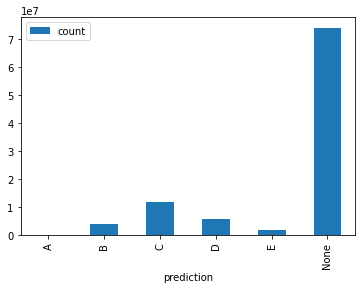

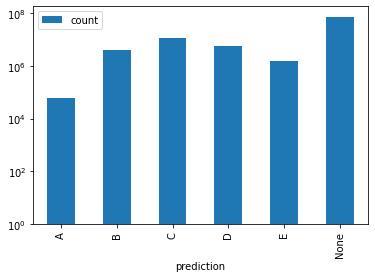

In [166]:
df.plot.bar(x="prediction", y="count")
df.plot.bar(x="prediction", y="count", log=True)

<AxesSubplot:xlabel='prediction'>

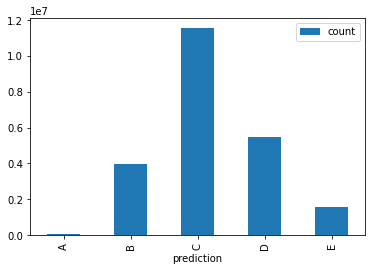

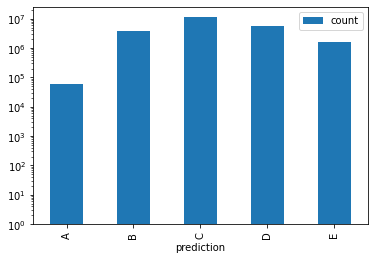

In [168]:
df[df.prediction != "None"].plot.bar(x="prediction", y="count")
df[df.prediction != "None"].plot.bar(x="prediction", y="count", log=True)

# Questions:
- If this table has predictions for revisions that happened over the last 3 months, how to get item quality items that have really old revisions.
    - undelete maybe. Some old revivions' ores score event was triggered somehow.
- If the latest revision has a few damaging edits that causes the ores score to change, and these edits may even have been almost immediately reverted, how do we capture this change in score? 
    - Either assume most lastest revisions are good enough. Thats the nature of data, its ever changing.
    - Or we can take into account the damaging prediction scores. This will be a bit involved because just because somthing is 'supposedly' damaging, doesnt mean it surely be reverted by someone. Should we take the leap of assuming that far? No.
- Is there a place where only the present scores of *all* items is stored? Should be do that then?
    - **event_sanitized** 
- Is the newest revid always the largest one?
    - because there are multiple revs in the exact same timestamp, upto the second. 
        - **rev_id, timestamp sort**
- Does the event sending process cause the same item, same rev to be run twice? Cuz different id but same everything else.
    - Yes
- How to handle deleted items? They have a last rev id, but then were deleted. E.g Q108898016
    - Don't care
- Namespace 0 is what I need. Articles. https://www.wikidata.org/wiki/Help:Namespaces
    - `spark.sql("select * from wmf_raw.mediawiki_project_namespace_map where snapshot = '2021-12' and dbname = 'wikidatawiki'")` is from site matrix

# # of Items in Wikidata


In [ ]:
WD.filter(f"context rlike '^<{wd}Q[0-9]+>$'").select("context").distinct().count()

In [111]:
total_q_items = 99_464_418

**99_464_418** Q-Items

# ORES Sanitized

## ORES sanitized table

In [10]:
## Namespaces
spark.sql("select * from wmf_raw.mediawiki_project_namespace_map where snapshot = '2021-12' and dbname = 'wikidatawiki'").show(50, truncate=False)

[Stage 0:>                                                          (0 + 1) / 1]

+----------------+------------+---------+------------------------+------------------------+--------------------+--------+
|hostname        |dbname      |namespace|namespace_canonical_name|namespace_localized_name|namespace_is_content|snapshot|
+----------------+------------+---------+------------------------+------------------------+--------------------+--------+
|www.wikidata.org|wikidatawiki|-2       |Media                   |Media                   |0                   |2021-12 |
|www.wikidata.org|wikidatawiki|-1       |Special                 |Special                 |0                   |2021-12 |
|www.wikidata.org|wikidatawiki|0        |                        |                        |1                   |2021-12 |
|www.wikidata.org|wikidatawiki|1        |Talk                    |Talk                    |0                   |2021-12 |
|www.wikidata.org|wikidatawiki|2        |User                    |User                    |0                   |2021-12 |
|www.wikidata.org|wikida

- 0: Q-IDs
- 120: Properties
- 146: Lexemes
- 640: Entity Schema

In [11]:
spark.table(ores_sanitized_table).printSchema()

root
 |-- _schema: string (nullable = true)
 |-- meta: struct (nullable = true)
 |    |-- uri: string (nullable = true)
 |    |-- request_id: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- dt: string (nullable = true)
 |    |-- domain: string (nullable = true)
 |    |-- stream: string (nullable = true)
 |-- database: string (nullable = true)
 |-- performer: struct (nullable = true)
 |    |-- user_id: long (nullable = true)
 |    |-- user_text: string (nullable = true)
 |    |-- user_groups: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- user_is_bot: boolean (nullable = true)
 |    |-- user_registration_dt: string (nullable = true)
 |    |-- user_edit_count: long (nullable = true)
 |-- page_id: long (nullable = true)
 |-- page_title: string (nullable = true)
 |-- page_namespace: long (nullable = true)
 |-- page_is_redirect: boolean (nullable = true)
 |-- rev_id: long (nullable = true)
 |-- rev_parent_id: long (nullable =

In [12]:
spark.sql(f"select COUNT(*) {from_ores_sanitized}").show(truncate=False)

[Stage 2:=============================>                             (1 + 1) / 2]

+--------+
|count(1)|
+--------+
|35216   |
+--------+



In [13]:
print(from_ores_sanitized_all)
spark.sql(f"select COUNT(*) {from_ores_sanitized_all}").show(truncate=False) ## 751_494_200

from event_sanitized.mediawiki_revision_score where database = 'wikidatawiki'


[Stage 4:===>                                               (686 + 420) / 10000]22/01/14 14:16:26 WARN NioEventLoop: Selector.select() returned prematurely 512 times in a row; rebuilding Selector io.netty.channel.nio.SelectedSelectionKeySetSelector@28bc2b99.
22/01/14 14:19:22 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
[Stage 6:>                                                          (0 + 1) / 1]

+---------+
|count(1) |
+---------+
|751494200|
+---------+



In [14]:
spark.sql(f"select COUNT(DISTINCT page_title) {from_ores_sanitized_all}").show(truncate=False) ##97649070

[Stage 10:>                                                         (0 + 1) / 1]

+--------------------------+
|count(DISTINCT page_title)|
+--------------------------+
|97649070                  |
+--------------------------+



**Data To Use**
- meta
    - uri  | https://www.wikidata.org/wiki/Q865920
    - request_id | 6faa2880-4b2d-4ce4-9df1-09f21d1ee5c1
    - id: string | c4147550-69cd-11ec-90b3-adba405186db
    - dt: request time
- page_namespace   | 0 
- page_title       | Q865920
- page_is_redirect | false
- page_id          | 817276 ??
- rev_id          | 1552974521
- rev_parent_id    | 1315288970
- rev_timestamp    | 2021-12-31T00:08:20Z
- scores (k/v)
    - model_name    | damaging
    - model_version | 0.5.0
    - prediction    | [false]
    - probability   | [false -> 0.9381482136786469, true -> 0.061851786321353165]
    
    
---
- request_id: Unique ID of the request that caused the event
- id: Unique ID of this event
- user_id: The user id that performed this change. This is optional, and will not be present for anonymous users.
- user_text: The text representation of the user that performed this change. Always present.

**How are revisions filtered.**
- Select only Q-id, i,e, Namespace = 0
- Filter out redirected pages
- For every Item:
    - Select latest edit
    - Select latest rev_id (same time can have multiple edits)
    - Select only the itemquality model
    - Select the prediction of the latest model version
- Deduplicate on: `"page_title", "rev_id", "rev_parent_id", "prediction", "model_version", "formatted_rev_timestamp"`

In [9]:
from pyspark.sql.types import IntegerType

def get_latest_time_partition(table_name=None, indices=None, partitions=None):
    """
    table_name: table name in hive
    indices: indices of time partitions. Should always be of length 4. Only required if table_name is provided.
        For datacenter=codfw/year=2022/month=2/day=1/hour=0, the indices will be [1,2,3,4]
        For year=2022/month=2/day=1/hour=0, the indices will be [0,1,2,3]
    paritions: the table created after the first step of the code below. 
        If it is a parquet file, load it as a dataframe, and send it in as `partitions`
    """
    if not partitions:
        partitions = spark.sql(f"show partitions {table_name}")\
                        .select(F.split("partition", '/').alias("partition"))\
                        .select(F.col("partition").getItem(indices[0]).alias("year"), F.col("partition").getItem(indices[1]).alias("month"),
                                F.col("partition").getItem(indices[2]).alias("day"), F.col("partition").getItem(indices[3]).alias("hour"))
        partitions = partitions.select([F.split(column, "=").getItem(1).cast(IntegerType()).alias(column) 
                                        for column in partitions.columns])

    year = partitions.select(F.max("year").alias("MAX")).limit(1).collect()[0].MAX
    month = partitions.filter(F.col("year") == year).select(F.max("month").alias("MAX")).limit(1).collect()[0].MAX
    day = partitions.filter((F.col("year") == year) & (F.col("month") == month))\
                            .select(F.max("day").alias("MAX")).limit(1).collect()[0].MAX
    hour = partitions.filter((F.col("year") == year) & (F.col("month") == month) & (F.col("day") == day))\
                            .select(F.max("hour").alias("MAX")).limit(1).collect()[0].MAX

    return year, month, day, hour

## First Run
Subsequemt runs should be through `Append Data`

In [10]:
latest_year, latest_month, latest_day, latest_hour = get_latest_time_partition(ores_sanitized_table, [1,2,3,4])
latest_year, latest_month, latest_day, latest_hour

[Stage 0:>                                                          (0 + 0) / 2]22/01/17 15:38:33 WARN TaskSetManager: Stage 0 contains a task of very large size (590 KB). The maximum recommended task size is 100 KB.


(2022, 1, 17, 11)

In [11]:
ores_sanitized_df = spark.sql(f"""select meta.id, meta.request_id, meta.dt, page_title, page_namespace, page_is_redirect,
                                  rev_id, rev_parent_id, rev_timestamp, scores, year, month, day, hour {from_ores_sanitized_all}""")

from pyspark.sql import Window
w = Window.partitionBy('page_title')

recent_revs = ores_sanitized_df\
                .filter("page_namespace == 0 AND page_is_redirect == false")\
                .withColumn("formatted_rev_timestamp",F.to_timestamp("rev_timestamp"))\
                .withColumn('last_rev_timestamp', F.max('formatted_rev_timestamp').over(w))\
                .withColumn('last_rev_id', F.max('rev_id').over(w))\
                .filter("last_rev_id == rev_id AND formatted_rev_timestamp == last_rev_timestamp")\
                .select("*", F.explode("scores")).select("*", "value.*")\
                .filter("model_name = 'itemquality'")\
                .withColumn('last_model_version', F.max('model_version').over(w))\
                .filter("last_model_version == model_version")\
                .drop("scores", "key", "value", "rev_timestamp", "model_name", "last_model_version",
                      "last_rev_id", "last_rev_timestamp", "page_namespace", "page_is_redirect")\
                .dropDuplicates(["page_title", "rev_id", "rev_parent_id", "prediction", "model_version", "formatted_rev_timestamp"])\
                .withColumn("prediction", F.col("prediction").getItem(0))\
                .withColumn("year", F.lit(latest_year))\
                .withColumn("month", F.lit(latest_month))\
                .withColumn("day", F.lit(latest_day))\
                .withColumn("hour", F.lit(latest_hour))

recent_revs.printSchema()

root
 |-- id: string (nullable = true)
 |-- request_id: string (nullable = true)
 |-- dt: string (nullable = true)
 |-- page_title: string (nullable = true)
 |-- rev_id: long (nullable = true)
 |-- rev_parent_id: long (nullable = true)
 |-- year: integer (nullable = false)
 |-- month: integer (nullable = false)
 |-- day: integer (nullable = false)
 |-- hour: integer (nullable = false)
 |-- formatted_rev_timestamp: timestamp (nullable = true)
 |-- model_version: string (nullable = true)
 |-- prediction: string (nullable = true)
 |-- probability: map (nullable = true)
 |    |-- key: string
 |    |-- value: double (valueContainsNull = true)



In [ ]:
import time ## ~90 minutes
start = time.time()

recent_revs.write.mode('overwrite').partitionBy("year", "month", "day", "hour").format("parquet").save("latest_wikidata_item_scores")

end = time.time()
print((end - start)/60)

In [14]:
recent_revs = spark.read.parquet("latest_wikidata_item_scores")
recent_revs

DataFrame[id: string, request_id: string, dt: string, page_title: string, rev_id: bigint, rev_parent_id: bigint, formatted_rev_timestamp: timestamp, model_version: string, prediction: string, probability: map<string,double>, year: int, month: int, day: int, hour: int]

In [56]:
recent_revs.select("page_title").distinct().count(),\
recent_revs.select("rev_id").distinct().count(),\
recent_revs.filter("page_title rlike '^Q[0-9]+$'").count(),\
recent_revs.count()

(87844547, 87844547, 87844547, 87844547)

In [ ]:
# recent_revs.groupby("rev_id").count().filter("count > 1").show(truncate=False)

In [109]:
total_items_with_scores = 87_844_547
total_items = 99_464_418 #96_569_155
## percent of items of wikidata covered
total_items_with_scores/total_items

0.8831755995395257

## Append New Data

In [15]:
latest_year, latest_month, latest_day, latest_hour = get_latest_time_partition(ores_sanitized_table, [1,2,3,4])
# latest_year, latest_month, latest_day, latest_hour

recent_revs = spark.read.parquet("latest_wikidata_item_scores")

previous_year, previous_month, previous_day, previous_hour = get_latest_time_partition(partitions=recent_revs)
# previous_year, previous_month, previous_day, previous_hour

latest_date = str(latest_year)+'-'+str(latest_month)+'-'+str(latest_day)+' '+str(latest_hour)
previous_date = str(previous_year)+'-'+str(previous_month)+'-'+str(previous_day)+' '+str(previous_hour)

latest_date, previous_date

[Stage 13:>                                                         (0 + 0) / 2]22/01/17 18:52:53 WARN TaskSetManager: Stage 13 contains a task of very large size (590 KB). The maximum recommended task size is 100 KB.


('2022-1-17 14', '2022-1-17 11')

In [16]:
recent_revs = spark.read.parquet("latest_wikidata_item_scores")
recent_revs.write.mode('overwrite').partitionBy("year", "month", "day", "hour").format("parquet").save("previous_wikidata_item_scores")
recent_revs = spark.read.parquet("previous_wikidata_item_scores")
## after updating everything, delete `previous_wikidata_item_scores`

ores_sanitized_df = spark.sql(f"""select meta.id, meta.request_id, meta.dt, 
                                  page_title, page_namespace, page_is_redirect,rev_id, 
                                  rev_parent_id, rev_timestamp, scores, year, month, day, hour 
                                  {from_ores_sanitized_all}""")

from pyspark.sql.types import StringType

ores_sanitized_df = ores_sanitized_df.withColumn("date", F.to_timestamp(F.concat(
                                                         F.col("year").cast(StringType()),F.lit('-'),
                                                         F.col("month").cast(StringType()),F.lit('-'),
                                                         F.col("day").cast(StringType()),F.lit(' '),
                                                         F.col("hour").cast(StringType())
                                                        ))
                                                )

from pyspark.sql import Window
w = Window.partitionBy('page_title')

new_revs = ores_sanitized_df.filter(F.col("date") > F.to_timestamp(F.lit(previous_date)))\
                .drop("date")\
                .filter("page_namespace == 0 AND page_is_redirect == false")\
                .withColumn("formatted_rev_timestamp",F.to_timestamp("rev_timestamp"))\
                .withColumn('last_rev_timestamp', F.max('formatted_rev_timestamp').over(w))\
                .withColumn('last_rev_id', F.max('rev_id').over(w))\
                .filter("last_rev_id == rev_id AND formatted_rev_timestamp == last_rev_timestamp")\
                .select("*", F.explode("scores")).select("*", "value.*")\
                .filter("model_name = 'itemquality'")\
                .withColumn('last_model_version', F.max('model_version').over(w))\
                .filter("last_model_version == model_version")\
                .drop("scores", "key", "value", "rev_timestamp", "model_name", "last_model_version",
                      "last_rev_id", "last_rev_timestamp", "page_namespace", "page_is_redirect")\
                .dropDuplicates(["page_title", "rev_id", "rev_parent_id", "prediction", "model_version", "formatted_rev_timestamp"])\
                .withColumn("prediction", F.col("prediction").getItem(0))\
                .withColumn("year", F.lit(latest_year))\
                .withColumn("month", F.lit(latest_month))\
                .withColumn("day", F.lit(latest_day))\
                .withColumn("hour", F.lit(latest_hour))

updated_revs = recent_revs\
                .withColumn('last_rev_timestamp', F.max('formatted_rev_timestamp').over(w))\
                .withColumn('last_rev_id', F.max('rev_id').over(w))\
                .withColumn('last_model_version', F.max('model_version').over(w))\
                .filter("last_rev_id == rev_id AND formatted_rev_timestamp == last_rev_timestamp "
                        "AND last_model_version == model_version")\
                .drop("last_model_version", "last_rev_id", "last_rev_timestamp")\
                .dropDuplicates(["page_title", "rev_id", "rev_parent_id", "prediction", "model_version", "formatted_rev_timestamp"])\

In [17]:
new_revs.count(), recent_revs.count(), updated_revs.count()

(38200, 87900774, 87900774)

In [18]:
import time
start = time.time()

updated_revs.write.mode('overwrite').partitionBy("year", "month", "day", "hour").format("parquet").save("latest_wikidata_item_scores")

end = time.time()
print((end - start)/60)

0.8374953031539917


In [110]:
recent_revs = spark.read.parquet("latest_wikidata_item_scores")
recent_revs

DataFrame[id: string, request_id: string, dt: string, page_title: string, rev_id: bigint, rev_parent_id: bigint, formatted_rev_timestamp: timestamp, model_version: string, prediction: string, probability: map<string,double>, year: int, month: int, day: int, hour: int]

In [20]:
recent_revs.select("page_title").distinct().count(),\
recent_revs.select("rev_id").distinct().count(),\
recent_revs.filter("page_title rlike '^Q[0-9]+$'").count(),\
recent_revs.count()

(87900774, 87900774, 87900774, 87900774)

In [21]:
# recent_revs.groupby("rev_id").count().filter("count > 1").show(truncate=False)

In [34]:
total_items_with_scores = 87_900_774
total_items = 99_464_418 #96_569_155
## percent of items of wikidata covered
total_items_with_scores/total_items

0.8837408971718912

### Prediction

In [114]:
df_item_scores = recent_revs.groupby("prediction").count().toPandas()
df_item_scores = df_item_scores.append({"prediction":"None", "count":total_items - total_items_with_scores}, ignore_index=True)
df_item_scores = df_item_scores.sort_values("prediction")
df_item_scores['percent'] = (df_item_scores['count']*100/total_items).round(3)
df_item_scores

,prediction,count,percent
0,A,63596,0.064
2,B,8324047,8.369
1,C,42391757,42.620
4,D,26990372,27.136
3,E,10131002,10.186
5,None,11619871,11.682


In [115]:
df_item_scores.to_csv("items_score_hist.csv", index=False)

<AxesSubplot:xlabel='prediction'>

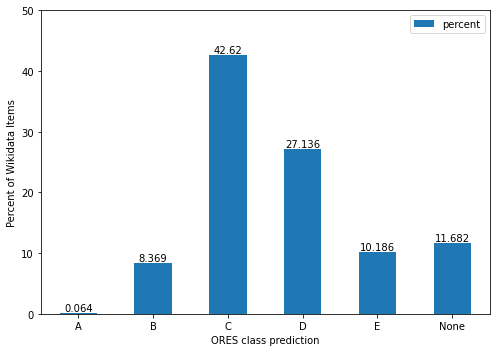

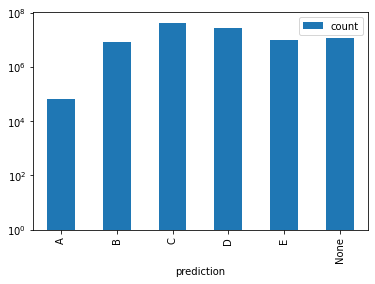

In [138]:
ax = df_item_scores.plot.bar(x="prediction", y="percent", figsize=(7,5))
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel("ORES class prediction")
plt.ylabel("Percent of Wikidata Items")
plt.xticks(rotation=0)
plt.ylim((0,50))
plt.tight_layout()
plt.savefig('items_predictions.png')
df_item_scores.plot.bar(x="prediction", y="count", log=True)

<AxesSubplot:xlabel='prediction'>

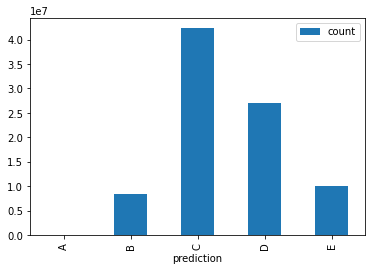

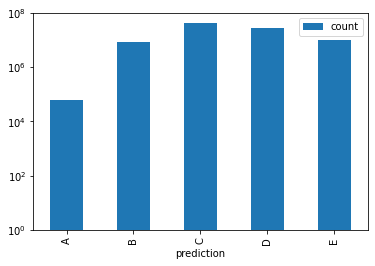

In [117]:
df_item_scores[df_item_scores.prediction != "None"].plot.bar(x="prediction", y="count")
df_item_scores[df_item_scores.prediction != "None"].plot.bar(x="prediction", y="count", log=True)

### Model Version

In [119]:
df_model_version = recent_revs.groupby("model_version").count().toPandas()
df_model_version = df_model_version.sort_values("model_version")
df_model_version['percent'] = (df_model_version['count']*100/total_items_with_scores).round(3)
df_model_version

,model_version,count,percent
0,0.4.0,20579508,23.427
1,0.5.0,67321266,76.637


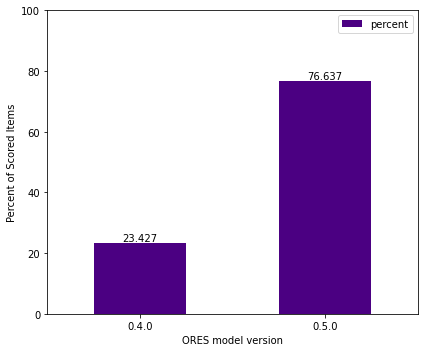

In [136]:
ax = df_model_version.plot.bar(x="model_version", y="percent", figsize=(6,5), color='indigo')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel("ORES model version")
plt.ylabel("Percent of Scored Items")
plt.ylim((0,100))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('model_versions.png')
# df_model_version.plot.bar(x="model_version", y="count", log=True)

# See Score distribution, Not just class distribution

In [35]:
recent_revs = spark.read.parquet("latest_wikidata_item_scores")
recent_revs

DataFrame[id: string, request_id: string, dt: string, page_title: string, rev_id: bigint, rev_parent_id: bigint, formatted_rev_timestamp: timestamp, model_version: string, prediction: string, probability: map<string,double>, year: int, month: int, day: int, hour: int]

In [73]:
from pyspark.sql.types import DoubleType

def calculate_ORES_scores(prob_map):
    return 5.0*prob_map["A"]+4.0*prob_map["B"]+3.0*prob_map["C"]+2.0*prob_map["D"]+1.0*prob_map["E"]

calculate_ORES_scores_udf = F.udf(calculate_ORES_scores)

In [75]:
ores_score_df = recent_revs.withColumn("ores_score", calculate_ORES_scores_udf(F.col("probability")))\
                            .select("page_title", "rev_id", "prediction", "ores_score", "model_version")\
                            .withColumn("ores_score", F.col("ores_score").cast(DoubleType()))

ores_score_df

DataFrame[page_title: string, rev_id: bigint, prediction: string, ores_score: double, model_version: string]

In [76]:
ores_score_df.selectExpr("max(ores_score) as max",
                         "min(ores_score) as min",
                         "avg(ores_score) as avg",
                         "stddev(ores_score) as stddev",
                         "percentile(ores_score, 0.25) as Q1",
                         "percentile(ores_score, 0.5) as Q2_Median",
                         "percentile(ores_score, 0.75) as Q3",
                        ).show(truncate=False)

[Stage 74:>                                                         (0 + 1) / 1]

+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|max              |min               |avg               |stddev            |Q1               |Q2_Median         |Q3                |
+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|4.970026371620923|1.0068978840592253|2.5600721088200213|0.7068520500714134|2.043707424483178|2.8435723098873855|2.9971646244634407|
+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+



In [ ]:
stats_histogram = ores_score_df.select('ores_score').rdd.flatMap(lambda x: x).histogram(100)
# stats_histogram

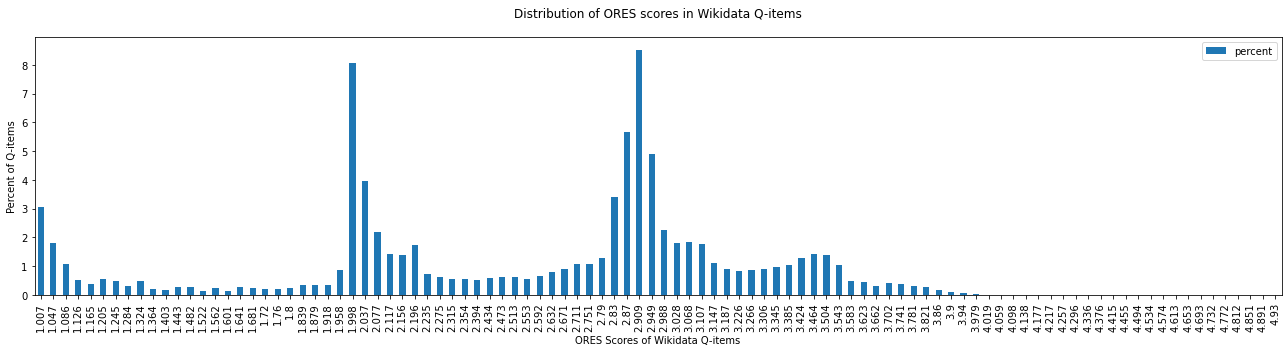

In [92]:
df_hist = pd.DataFrame(
    list(zip(*stats_histogram)), 
    columns=['bin', 'frequency']
)
df_hist['bin'] = df_hist['bin'].round(3)
df_hist['percent'] = (df_hist['frequency']*100/total_q_items).round(3)
# display(df_hist)

df_hist[['percent', 'bin']].set_index('bin').plot(kind='bar', figsize=(18,5));

# df_hist.set_index('bin').plot(kind='bar', figsize=(18,5), logy=True);
plt.xlabel("ORES Scores of Wikidata Q-items")
plt.ylabel("Percent of Q-items")
plt.title("Distribution of ORES scores in Wikidata Q-items\n")
# plt.xlim((0,5))
plt.tight_layout()
plt.savefig("ores_score_distribution.png")

In [139]:
stats_histogram = ores_score_df.select('ores_score').rdd.flatMap(lambda x: x).histogram(list(np.arange(0,5.1,0.1)))
# stats_histogram

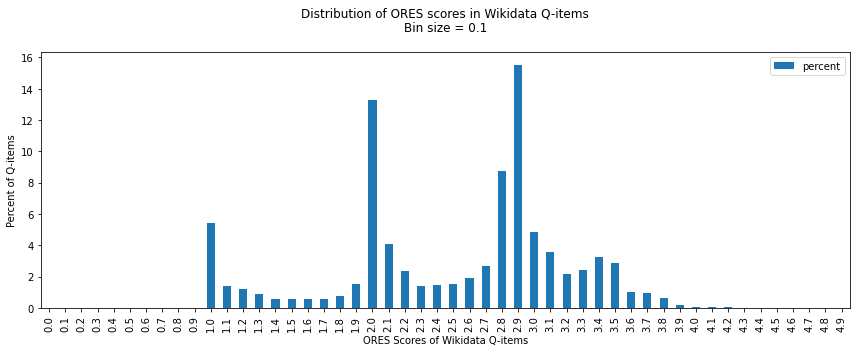

In [140]:
df_hist = pd.DataFrame(
    list(zip(*stats_histogram)), 
    columns=['bin', 'frequency']
)
df_hist['bin'] = df_hist['bin'].round(2)
df_hist['percent'] = (df_hist['frequency']*100/total_q_items).round(3)
# display(df_hist)

df_hist[['percent', 'bin']].set_index('bin').plot(kind='bar', figsize=(12,5));

# df_hist.set_index('bin').plot(kind='bar', figsize=(18,5), logy=True);
plt.xlabel("ORES Scores of Wikidata Q-items")
plt.ylabel("Percent of Q-items")
plt.title("Distribution of ORES scores in Wikidata Q-items\nBin size = 0.1\n")
# plt.xlim((0,5))
plt.tight_layout()
plt.savefig("ores_score_distribution.png")

In [107]:
stats_histogram = ores_score_df.select('ores_score').rdd.flatMap(lambda x: x).histogram(list(np.arange(0,6,1)))

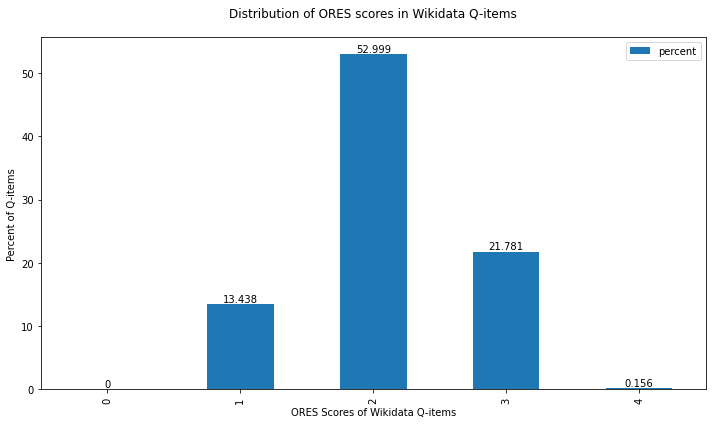

In [108]:
df_hist = pd.DataFrame(
    list(zip(*stats_histogram)), 
    columns=['bin', 'frequency']
)
df_hist['bin'] = df_hist['bin'].round(2)
df_hist['percent'] = (df_hist['frequency']*100/total_q_items).round(3)
# display(df_hist)

ax = df_hist[['percent', 'bin']].set_index('bin').plot(kind='bar', figsize=(10,6));

# df_hist.set_index('bin').plot(kind='bar', figsize=(18,5), logy=True);
plt.xlabel("ORES Scores of Wikidata Q-items")
plt.ylabel("Percent of Q-items")
plt.title("Distribution of ORES scores in Wikidata Q-items\n")
for container in ax.containers:
    ax.bar_label(container)
# plt.xlim((0,5))
plt.tight_layout()

# Score and prediction analysis per Subgraph

In [ ]:
instance_pdf = pd.read_csv('../WD subgraph/all_instances.csv')
top_instances = pd.read_csv('../WD subgraph/top_instances.csv')

## URI to Q-ID and Label mapping
subgraph_code_uri = top_instances[['code', 'label']]
subgraph_code_uri['subgraph'] = subgraph_code_uri['code'].apply(lambda x: "<%s%s>" %(wd,x))

## Get Astronomical Objects
query = """
        SELECT ?subclass ?subclassLabel
        WHERE
        {
          ?subclass wdt:P279* wd:Q6999.
          SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
        }
        """
astro_subclasses = get_results(query, ['subclass', 'subclassLabel']).rename(columns={'subclassLabel':'label'})
astro_subclasses['code'] = astro_subclasses['subclass'].apply(lambda x: x.split('/')[-1])
print("Number of Astro subclasses", len(astro_subclasses))

items = spark.sql(f"select subject as item, object as instance {from_clause} and predicate='<{p31}>'")
temp = astro_subclasses[['subclass']]
temp['subclass'] = temp['subclass'].apply(lambda x: '<'+x+'>')
astro_subclasses_pydf = spark.createDataFrame(temp)
all_astro_items_df = items.join(astro_subclasses_pydf, items.instance == astro_subclasses_pydf.subclass).select('item').distinct()

## Related Astro Triples
astro_subgraph = WD.join(all_astro_items_df, WD.context==all_astro_items_df.item, 'inner').select("subject", "predicate", "object").distinct()

## Get ALL SUBGRAPHS

## Remove things that are almost completely in scholarly articles (but keeping scholarly articles)
to_remove = astro_subclasses['code'].values.tolist() + ['Q7318358', 'Q2782326', 'Q871232']
other_top_instances = top_instances[~top_instances['code'].isin(to_remove)]
subgraphs = ">','<".join([wd+item for item in other_top_instances['code'].values.tolist()])

full_items = spark.sql(f"""
                        select object as subgraph, subject as item
                        {from_clause}
                        and predicate='<{p31}>'
                        and object in ('<{subgraphs}>')
                        """)

## All items
full_items = full_items.unionByName(all_astro_items_df.withColumn('subgraph',F.lit('<http://www.wikidata.org/entity/Q6999>')))

## All subgraphs
full_subgraphs = WD.join(full_items, WD.context == full_items.item, 'inner').drop('context', 'wiki', 'date')
full_subgraphs = full_subgraphs.withColumn('predicate_code', pred2codeUDF('predicate'))

full_items, full_subgraphs

I don't need subgraph-triples now though. Just **subgraph-items**.

In [303]:
full_items.withColumn("item", pred2codeUDF("item")).filter("item not rlike '^Q[0-9]+$'").show(truncate=False)

[Stage 190:==========================================>              (3 + 1) / 4]

+------------------------------------------+---------+
|subgraph                                  |item     |
+------------------------------------------+---------+
|<http://www.wikidata.org/entity/Q1520033> |L410898  |
|<http://www.wikidata.org/entity/Q86850539>|L277324  |
|<http://www.wikidata.org/entity/Q1520033> |L302684  |
|<http://www.wikidata.org/entity/Q1520033> |L39743-S2|
|<http://www.wikidata.org/entity/Q1520033> |L250384  |
|<http://www.wikidata.org/entity/Q1520033> |L409111  |
|<http://www.wikidata.org/entity/Q1520033> |L401781  |
|<http://www.wikidata.org/entity/Q1520033> |L407149  |
|<http://www.wikidata.org/entity/Q1520033> |L405618  |
|<http://www.wikidata.org/entity/Q1520033> |L503829  |
|<http://www.wikidata.org/entity/Q86850539>|L260625  |
|<http://www.wikidata.org/entity/Q1520033> |L251952  |
|<http://www.wikidata.org/entity/Q1520033> |L494656  |
|<http://www.wikidata.org/entity/Q86850539>|L255891  |
|<http://www.wikidata.org/entity/Q1520033> |L39197   |
|<http://w

In [307]:
full_items.withColumn("item", pred2codeUDF("item")).filter("item not rlike '^Q[0-9]+$'")\
          .filter(f"subgraph == '<{wd}Q13442814>'").show(truncate=False)

[Stage 202:==================================================>(3146 + 2) / 3148]

+--------+----+
|subgraph|item|
+--------+----+
+--------+----+



In [ ]:
full_items = full_items.withColumn("item", pred2codeUDF("item")).filter("item rlike '^Q[0-9]+$'") ## 22k not like Q-ID
full_items.count(), total_q_items ## (89051118, 99464418)

In [171]:
## full items are items that are subclass of top 340 subgraphs
## They are 90% of all Wikidata items
89_051_118*100/99_464_418

89.53062792766757

In [ ]:
recent_revs_subgraph = recent_revs.join(full_items, recent_revs.page_title==full_items.item).drop("id", "request_id", "dt", "year", "month","day","hour","item")
recent_revs_subgraph

In [173]:
recent_revs_subgraph.count(), recent_revs.count()

(80897270, 87900774)

In [195]:
top_subgraph_items_with_scores = 80897270

In [197]:
## percent of top subgraph items with a score, 
## percent of all WD items with a score
## top subgraph items with a score / all items

80_897_270*100/89_051_118, 87_900_774*100/99_464_418, 80_897_270*100/99_464_418

(90.84363208107057, 88.37408971718912, 81.33287423448253)

In [180]:
subgraph_predclass = recent_revs_subgraph.groupby(["subgraph", "prediction"]).count().toPandas()
subgraph_predclass_labeled = subgraph_predclass.merge(subgraph_code_uri, on="subgraph").drop(columns="subgraph").rename(columns={"code":"subgraph"})
subgraph_predclass_labeled.to_csv("subgraph_predclass_count.csv", index=False)
subgraph_predclass_labeled

,prediction,count,subgraph,label
0,D,6469,Q166735,swamp
1,E,747,Q166735,swamp
2,C,468,Q166735,swamp
3,B,6,Q166735,swamp
4,A,3,Q618779,award
...,...,...,...,...
1377,D,6327,Q160091,plain
1378,E,3495,Q160091,plain
1379,B,9,Q160091,plain
1380,D,17121,Q7604693,Statutory Rules of Northern Ireland


In [186]:
item_per_subgraph = full_items.groupby("subgraph").count().toPandas()
item_per_subgraph['subgraph'] = item_per_subgraph['subgraph'].apply(lambda x: x.split('/')[-1][:-1])
item_per_subgraph.to_csv("item_per_subgraph.csv", index=False)
item_per_subgraph ## not used cuz I took percent with only items that have a score

,subgraph,count
0,Q41176,283240
1,Q16887380,21229
2,Q253019,41323
3,Q12308941,37652
4,Q12317349,13635
...,...,...
333,Q1002697,54581
334,Q178561,14408
335,Q575759,16311
336,Q67015940,26161


In [234]:
subgraph_ores = subgraph_predclass_labeled.merge(subgraph_predclass_labeled.groupby("subgraph")['count'].sum().to_frame().reset_index().rename(columns={"count":"item_count"}), 
                                                 on="subgraph")
subgraph_ores['percent_subgraph'] = (subgraph_ores['count']*100/subgraph_ores['item_count']).round(3)
subgraph_ores['percent_all_scored_subgraph_items'] = (subgraph_ores['count']*100/top_subgraph_items_with_scores).round(3)
subgraph_ores

,prediction,count,subgraph,label,item_count,percent_subgraph,percent_all_scored_subgraph_items
0,D,6469,Q166735,swamp,7690,84.122,0.008
1,E,747,Q166735,swamp,7690,9.714,0.001
2,C,468,Q166735,swamp,7690,6.086,0.001
3,B,6,Q166735,swamp,7690,0.078,0.000
4,A,3,Q618779,award,17375,0.017,0.000
...,...,...,...,...,...,...,...
1377,D,6327,Q160091,plain,10329,61.255,0.008
1378,E,3495,Q160091,plain,10329,33.837,0.004
1379,B,9,Q160091,plain,10329,0.087,0.000
1380,D,17121,Q7604693,Statutory Rules of Northern Ireland,17121,100.000,0.021


In [248]:
df = df_item_scores[df_item_scores['prediction']!='None']
df['percent_all_scored_items'] = (df_item_scores['count']*100/total_items_with_scores).round(3)
df = df.drop(columns=["count", "percent"])
df_diff = df.merge(subgraph_ores, on='prediction')
df_diff["percent_diff"] = df_diff["percent_subgraph"]-df_diff["percent_all_scored_items"]

df_diff

/home/akhatun/.conda/envs/2021-10-11T16.52.27_akhatun/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,prediction,percent_all_scored_items,count,subgraph,label,item_count,percent_subgraph,percent_all_scored_subgraph_items,percent_diff
0,A,0.072,3,Q618779,award,17375,0.017,0.000,-0.055
1,A,0.072,1,Q14204246,Wikimedia project page,31298,0.003,0.000,-0.069
2,A,0.072,12,Q4164871,position,117200,0.010,0.000,-0.062
3,A,0.072,9,Q12308941,male given name,37643,0.024,0.000,-0.048
4,A,0.072,2,Q189004,college,25793,0.008,0.000,-0.064
...,...,...,...,...,...,...,...,...,...
1377,E,11.533,3054,Q18918145,academic journal article,22266,13.716,0.004,2.183
1378,E,11.533,13541,Q459297,qanat,13596,99.595,0.017,88.062
1379,E,11.533,50,Q2732840,Gram panchayat,4028,1.241,0.000,-10.292
1380,E,11.533,181,Q50231,administrative territorial entity of the Peopl...,516,35.078,0.000,23.545


In [310]:
d = df_diff[['prediction', 'percent_all_scored_items', 'subgraph', 'label', 'item_count',
          'count', 'percent_subgraph', 'percent_all_scored_subgraph_items', 'percent_diff']]
d.columns = ['prediction', 'overall_percent_of_prediction_in_wikidata', 
             'subgraph', 'label', 'number_of_items_in_subgraph', 'number_of_items_in_this_subgraphs_prediction_category',
             'percent_subgraph', 'percent_all_scored_subgraph_items', 'percent_diff']
d.to_csv("subgraph_prediction_classes_diff.csv", index=False)
d

,prediction,overall_percent_of_prediction_in_wikidata,subgraph,label,number_of_items_in_subgraph,number_of_items_in_this_subgraphs_prediction_category,percent_subgraph,percent_all_scored_subgraph_items,percent_diff
0,A,0.072,Q618779,award,17375,3,0.017,0.000,-0.055
1,A,0.072,Q14204246,Wikimedia project page,31298,1,0.003,0.000,-0.069
2,A,0.072,Q4164871,position,117200,12,0.010,0.000,-0.062
3,A,0.072,Q12308941,male given name,37643,9,0.024,0.000,-0.048
4,A,0.072,Q189004,college,25793,2,0.008,0.000,-0.064
...,...,...,...,...,...,...,...,...,...
1377,E,11.533,Q18918145,academic journal article,22266,3054,13.716,0.004,2.183
1378,E,11.533,Q459297,qanat,13596,13541,99.595,0.017,88.062
1379,E,11.533,Q2732840,Gram panchayat,4028,50,1.241,0.000,-10.292
1380,E,11.533,Q50231,administrative territorial entity of the Peopl...,516,181,35.078,0.000,23.545


/home/akhatun/.conda/envs/2021-10-11T16.52.27_akhatun/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/akhatun/.conda/envs/2021-10-11T16.52.27_akhatun/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


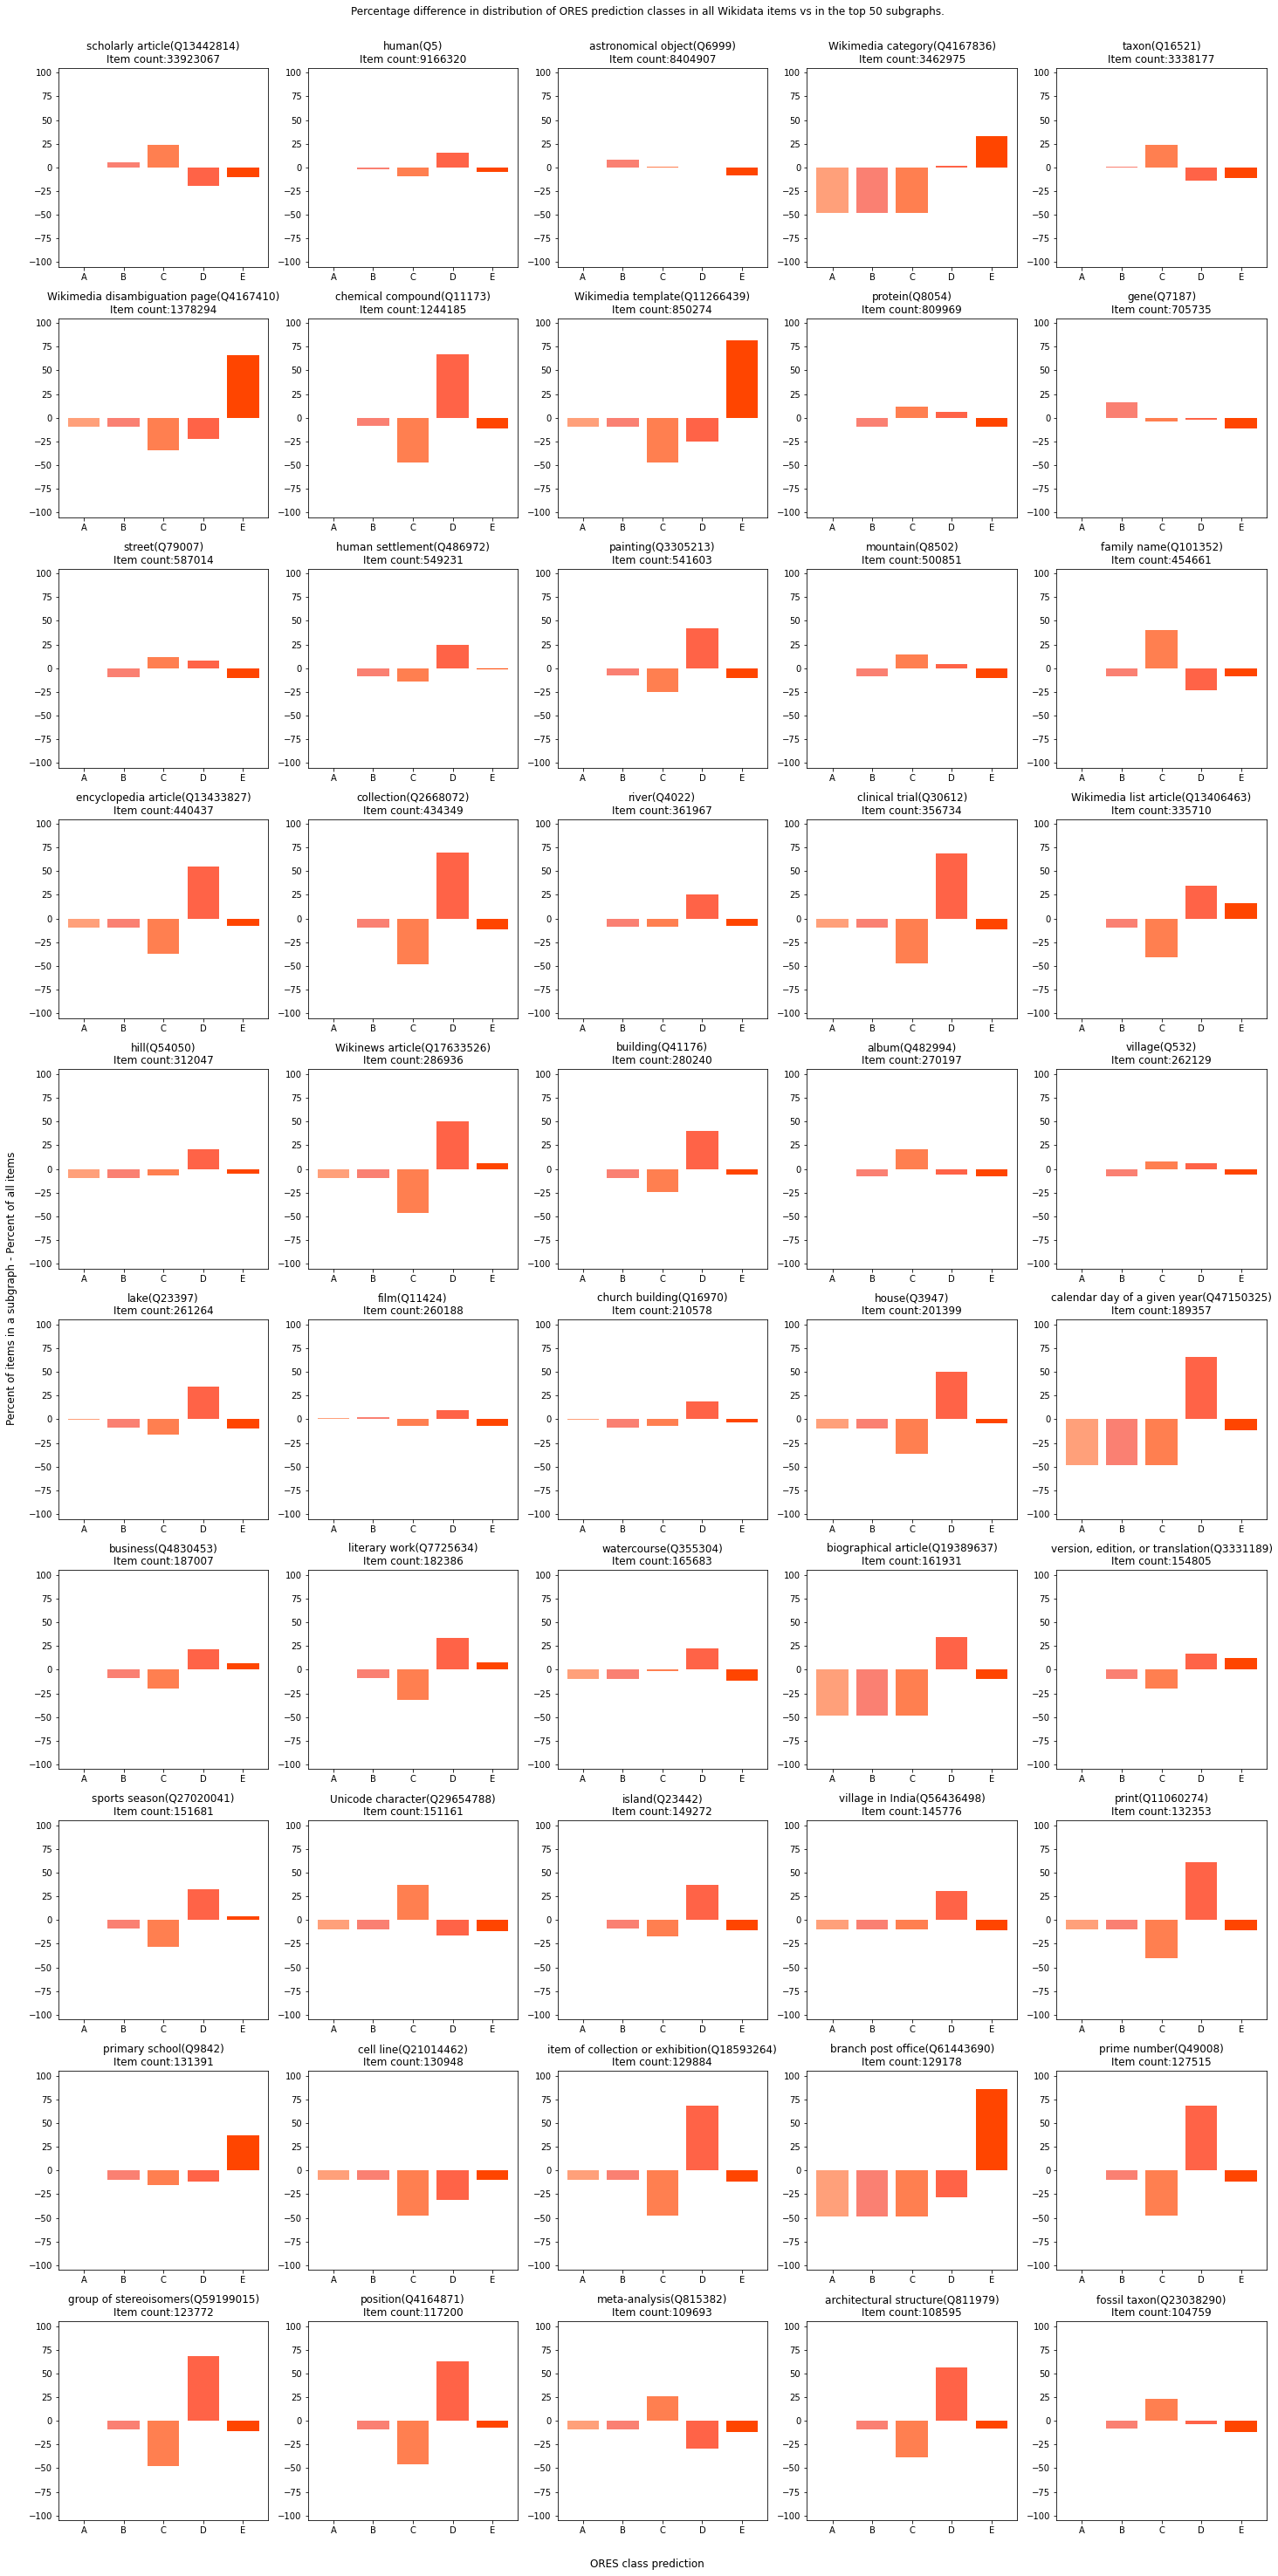

In [261]:
top_50_subgraphs = subgraph_predclass_labeled.groupby("subgraph")['count'].sum().to_frame().sort_values("count", ascending = False).reset_index()['subgraph'].head(50).tolist()


limit = 50
sm = int(limit/10)
fig, axes = plt.subplots(10, sm, figsize=(20,40))
ax_id = 0
mp = {"A": "lightsalmon","B":"salmon","C":"coral","D":"tomato","E":"orangered"}

for sub_id in top_50_subgraphs:
    df = df_diff[df_diff['subgraph'] == sub_id]
    label = df['label'].values[0]
    for pred in "ABCDE":
        if pred not in df["prediction"].unique():
            row = df.head(1)
            row["prediction"] = pred
            row["percent_diff"] = 0 - row["percent_all_scored_items"]
            df = df.append(row, ignore_index=True)
    df = df.sort_values('prediction')
    df['colors'] = df['prediction'].map(mp)
    ax = axes[int(ax_id/sm),ax_id%sm]
    ax.bar(x=df['prediction'], height=df['percent_diff'], color=df['colors'])
    ax.set_title("%s(%s)\n"
                 "Item count:%d"
                 %(label, sub_id, df['item_count'].values[0])
                )
    ax.set_ylim([-105,105])
    ax_id += 1
    # if ax_id == limit:
    #     break
plt.tight_layout()
fig.supxlabel("ORES class prediction", y=-0.01)
fig.supylabel("Percent of items in a subgraph - Percent of all items", x=-0.01)
plt.suptitle("Percentage difference in distribution of ORES prediction classes in all Wikidata items vs "
             "in the top 50 subgraphs.", y=1.01)
plt.savefig('top_50_ORES_pred_class_dist_diffs.png')

## Find subgraphs with most A,B,E categories


#### Top Subgraphs by Item counts in each class

In [271]:
cond = df_diff.groupby('prediction')['count'].transform(max) == df_diff['count']
## same as percent_all_scored_subgraph_items
df_diff[cond]

,prediction,percent_all_scored_items,count,subgraph,label,item_count,percent_subgraph,percent_all_scored_subgraph_items,percent_diff
81,A,0.072,25967,Q5,human,9166320,0.283,0.032,0.211
336,B,9.476,5168895,Q13442814,scholarly article,33923067,15.237,6.389,5.761
632,C,48.258,24539904,Q13442814,scholarly article,33923067,72.340,30.335,24.082
898,D,30.725,4247974,Q5,human,9166320,46.343,5.251,15.618
1125,E,11.533,1546826,Q4167836,Wikimedia category,3462975,44.668,1.912,33.135


In [290]:
## get top 5 for each class

## same as percent_all_scored_subgraph_items
df_diff.sort_values(['prediction', 'count'], ascending=[True, False]).groupby('prediction').head(5)

,prediction,percent_all_scored_items,count,subgraph,label,item_count,percent_subgraph,percent_all_scored_subgraph_items,percent_diff
81,A,0.072,25967,Q5,human,9166320,0.283,0.032,0.211
29,A,0.072,11513,Q484170,commune of France,45578,25.260,0.014,25.188
103,A,0.072,6461,Q16521,taxon,3338177,0.194,0.008,0.122
111,A,0.072,3739,Q11424,film,260188,1.437,0.005,1.365
72,A,0.072,1525,Q11173,chemical compound,1244185,0.123,0.002,0.051
336,B,9.476,5168895,Q13442814,scholarly article,33923067,15.237,6.389,5.761
175,B,9.476,1516261,Q6999,astronomical object,8404907,18.040,1.874,8.564
283,B,9.476,693124,Q5,human,9166320,7.562,0.857,-1.914
320,B,9.476,349153,Q16521,taxon,3338177,10.459,0.432,0.983
214,B,9.476,184886,Q7187,gene,705735,26.198,0.229,16.722


In [295]:
d = df_diff.sort_values(['prediction', 'count'], ascending=[True, False]).groupby('prediction').head(5)\
       [['prediction', 'subgraph', 'label', 'count', 'percent_all_scored_subgraph_items', 'percent_subgraph', 'percent_diff']]
d['percent_diff'] = d['percent_diff'].round(2)
d['percent_all_scored_subgraph_items'] = d['percent_all_scored_subgraph_items'].round(2)
d['percent_subgraph'] = d['percent_subgraph'].round(2)
d['count'] = d['count'].apply(lambda x: '{:,}'.format(x))
df2wikitable(d)

|-
|A||Q5||human||25,967||0.03||0.28||0.21
|-
|A||Q484170||commune of France||11,513||0.01||25.26||25.19
|-
|A||Q16521||taxon||6,461||0.01||0.19||0.12
|-
|A||Q11424||film||3,739||0.0||1.44||1.36
|-
|A||Q11173||chemical compound||1,525||0.0||0.12||0.05
|-
|B||Q13442814||scholarly article||5,168,895||6.39||15.24||5.76
|-
|B||Q6999||astronomical object||1,516,261||1.87||18.04||8.56
|-
|B||Q5||human||693,124||0.86||7.56||-1.91
|-
|B||Q16521||taxon||349,153||0.43||10.46||0.98
|-
|B||Q7187||gene||184,886||0.23||26.2||16.72
|-
|C||Q13442814||scholarly article||24,539,904||30.34||72.34||24.08
|-
|C||Q6999||astronomical object||4,107,902||5.08||48.88||0.62
|-
|C||Q5||human||3,572,265||4.42||38.97||-9.29
|-
|C||Q16521||taxon||2,407,628||2.98||72.12||23.87
|-
|C||Q4167836||Wikimedia category||808,759||1.0||23.35||-24.9
|-
|D||Q5||human||4,247,974||5.25||46.34||15.62
|-
|D||Q13442814||scholarly article||3,816,100||4.72||11.25||-19.48
|-
|D||Q6999||astronomical object||2,552,206||3.16||30.37||-0.36

#### Top subgraphs by percent_in_subgraph in each class 

In [269]:
cond = df_diff.groupby('prediction')['percent_subgraph'].transform(max) == df_diff['percent_subgraph']
df_diff[cond]

,prediction,percent_all_scored_items,count,subgraph,label,item_count,percent_subgraph,percent_all_scored_subgraph_items,percent_diff
29,A,0.072,11513,Q484170,commune of France,45578,25.260,0.014,25.188
371,B,9.476,12712,Q107103143,Induced pluripotent stem cell line,12730,99.859,0.016,90.383
483,C,48.258,12386,Q6453643,decree law,12391,99.960,0.015,51.702
914,D,30.725,14280,Q106474968,ethnic group by settlement in Macedonia,14280,100.000,0.018,69.275
1027,D,30.725,13777,Q6451276,Congressional Research Service report,13777,100.000,0.017,69.275
1068,D,30.725,17121,Q7604693,Statutory Rules of Northern Ireland,17121,100.000,0.021,69.275
1069,D,30.725,33420,Q100532807,Irish Statutory Instrument,33420,100.000,0.041,69.275
1127,E,11.533,2561,Q26267864,Wikimedia KML file,2564,99.883,0.003,88.350


In [278]:
## get top 5 for each class

## same as percent_all_scored_subgraph_items
df_diff.sort_values(['prediction', 'percent_subgraph'], ascending=[True, False]).groupby('prediction').head(10)

,prediction,percent_all_scored_items,count,subgraph,label,item_count,percent_subgraph,percent_all_scored_subgraph_items,percent_diff
29,A,0.072,11513,Q484170,commune of France,45578,25.260,0.014,25.188
125,A,0.072,174,Q34770,language,9458,1.840,0.000,1.768
9,A,0.072,794,Q7889,video game,45126,1.760,0.001,1.688
57,A,0.072,194,Q891723,public company,12377,1.567,0.000,1.495
111,A,0.072,3739,Q11424,film,260188,1.437,0.005,1.365
148,A,0.072,135,Q3957,town,14268,0.946,0.000,0.874
114,A,0.072,104,Q3918,university,13631,0.763,0.000,0.691
62,A,0.072,271,Q5398426,television series,59171,0.458,0.000,0.386
10,A,0.072,53,Q192287,subdivisions of Russia,15923,0.333,0.000,0.261
30,A,0.072,38,Q35127,website,12020,0.316,0.000,0.244


In [298]:
d = df_diff.sort_values(['prediction', 'percent_subgraph'], ascending=[True, False]).groupby('prediction').head(5)\
       [['prediction', 'subgraph', 'label', 'count', 'percent_all_scored_subgraph_items', 'percent_subgraph', 'percent_diff']]
d['percent_diff'] = d['percent_diff'].round(2)
d['percent_all_scored_subgraph_items'] = d['percent_all_scored_subgraph_items'].round(2)
d['percent_subgraph'] = d['percent_subgraph'].round(2)
d['count'] = d['count'].apply(lambda x: '{:,}'.format(x))
df2wikitable(d)

|-
|A||Q484170||commune of France||11,513||0.01||25.26||25.19
|-
|A||Q34770||language||174||0.0||1.84||1.77
|-
|A||Q7889||video game||794||0.0||1.76||1.69
|-
|A||Q891723||public company||194||0.0||1.57||1.5
|-
|A||Q11424||film||3,739||0.0||1.44||1.36
|-
|B||Q107103143||Induced pluripotent stem cell line||12,712||0.02||99.86||90.38
|-
|B||Q107102664||cell line from embryonic stem cells||16,079||0.02||99.85||90.38
|-
|B||Q27555384||transformed cell line||47,875||0.06||99.77||90.3
|-
|B||Q27671617||finite cell line||11,099||0.01||99.52||90.04
|-
|B||Q21014462||cell line||129,906||0.16||99.2||89.73
|-
|C||Q6453643||decree law||12,386||0.02||99.96||51.7
|-
|C||Q814254||feature||10,702||0.01||99.39||51.13
|-
|C||Q104093746||lake or pond||31,050||0.04||99.28||51.03
|-
|C||Q22969563||bodendenkmal||49,768||0.06||99.18||50.92
|-
|C||Q21199||natural number||10,156||0.01||97.78||49.52
|-
|D||Q106474968||ethnic group by settlement in Macedonia||14,280||0.02||100.0||69.28
|-
|D||Q6451276||Congressio

#### Top subgraphs by most (+)'ve diff

In [280]:
cond = df_diff.groupby('prediction')['percent_diff'].transform(max) == df_diff['percent_diff']
## same as percent_subgraph
df_diff[cond]

,prediction,percent_all_scored_items,count,subgraph,label,item_count,percent_subgraph,percent_all_scored_subgraph_items,percent_diff
29,A,0.072,11513,Q484170,commune of France,45578,25.260,0.014,25.188
371,B,9.476,12712,Q107103143,Induced pluripotent stem cell line,12730,99.859,0.016,90.383
483,C,48.258,12386,Q6453643,decree law,12391,99.960,0.015,51.702
914,D,30.725,14280,Q106474968,ethnic group by settlement in Macedonia,14280,100.000,0.018,69.275
1027,D,30.725,13777,Q6451276,Congressional Research Service report,13777,100.000,0.017,69.275
1068,D,30.725,17121,Q7604693,Statutory Rules of Northern Ireland,17121,100.000,0.021,69.275
1069,D,30.725,33420,Q100532807,Irish Statutory Instrument,33420,100.000,0.041,69.275
1127,E,11.533,2561,Q26267864,Wikimedia KML file,2564,99.883,0.003,88.350


#### Top subgraphs by most (-)'ve diff

In [281]:
cond = df_diff.groupby('prediction')['percent_diff'].transform(min) == df_diff['percent_diff']
## same as percent_subgraph
df_diff[cond]

,prediction,percent_all_scored_items,count,subgraph,label,item_count,percent_subgraph,percent_all_scored_subgraph_items,percent_diff
44,A,0.072,1,Q13406463,Wikimedia list article,335710,0.000,0.0,-0.072
54,A,0.072,1,Q79007,street,587014,0.000,0.0,-0.072
55,A,0.072,2,Q101352,family name,454661,0.000,0.0,-0.072
115,A,0.072,7,Q13442814,scholarly article,33923067,0.000,0.0,-0.072
271,B,9.476,1,Q49008,prime number,127515,0.001,0.0,-9.475
301,B,9.476,3,Q17633526,Wikinews article,286936,0.001,0.0,-9.475
725,C,48.258,1,Q3508250,Syndicat intercommunal,14332,0.007,0.0,-48.251
841,D,30.725,1,Q21014462,cell line,130948,0.001,0.0,-30.724
1190,E,11.533,1,Q29654788,Unicode character,151161,0.001,0.0,-11.532
1208,E,11.533,1,Q49008,prime number,127515,0.001,0.0,-11.532


In [296]:
## get top 10 for each class
df_diff.sort_values(['prediction', 'percent_diff'], ascending=[True, True]).groupby('prediction').head(10)

,prediction,percent_all_scored_items,count,subgraph,label,item_count,percent_subgraph,percent_all_scored_subgraph_items,percent_diff
44,A,0.072,1,Q13406463,Wikimedia list article,335710,0.000,0.0,-0.072
54,A,0.072,1,Q79007,street,587014,0.000,0.0,-0.072
55,A,0.072,2,Q101352,family name,454661,0.000,0.0,-0.072
115,A,0.072,7,Q13442814,scholarly article,33923067,0.000,0.0,-0.072
6,A,0.072,1,Q22808320,Wikimedia human name disambiguation page,70686,0.001,0.0,-0.071
14,A,0.072,2,Q27020041,sports season,151681,0.001,0.0,-0.071
58,A,0.072,7,Q8054,protein,809969,0.001,0.0,-0.071
68,A,0.072,6,Q2668072,collection,434349,0.001,0.0,-0.071
77,A,0.072,3,Q41176,building,280240,0.001,0.0,-0.071
106,A,0.072,1,Q9842,primary school,131391,0.001,0.0,-0.071


In [299]:
## get top 10 for each class

atleast_x_items = 10
df_diff[df_diff['count']>atleast_x_items].sort_values(['prediction', 'percent_diff'], ascending=[True, True]).groupby('prediction').head(10)

,prediction,percent_all_scored_items,count,subgraph,label,item_count,percent_subgraph,percent_all_scored_subgraph_items,percent_diff
140,A,0.072,17,Q8502,mountain,500851,0.003,0.000,-0.069
41,A,0.072,29,Q7187,gene,705735,0.004,0.000,-0.068
87,A,0.072,13,Q532,village,262129,0.005,0.000,-0.067
22,A,0.072,16,Q23397,lake,261264,0.006,0.000,-0.066
97,A,0.072,34,Q3305213,painting,541603,0.006,0.000,-0.066
52,A,0.072,24,Q4022,river,361967,0.007,0.000,-0.065
16,A,0.072,797,Q6999,astronomical object,8404907,0.009,0.001,-0.063
2,A,0.072,12,Q4164871,position,117200,0.010,0.000,-0.062
85,A,0.072,32,Q482994,album,270197,0.012,0.000,-0.060
35,A,0.072,16,Q59199015,group of stereoisomers,123772,0.013,0.000,-0.059


In [301]:
atleast_x_items = 10
d = df_diff[df_diff['count']>atleast_x_items].sort_values(['prediction', 'percent_diff'], ascending=[True, True]).groupby('prediction').head(5)
d = d[['prediction', 'subgraph', 'label', 'count', 'percent_all_scored_subgraph_items', 'percent_subgraph', 'percent_diff']]
d['percent_diff'] = d['percent_diff'].round(2)
d['percent_all_scored_subgraph_items'] = d['percent_all_scored_subgraph_items'].round(2)
d['percent_subgraph'] = d['percent_subgraph'].round(2)
d['count'] = d['count'].apply(lambda x: '{:,}'.format(x))
df2wikitable(d)

|-
|A||Q8502||mountain||17||0.0||0.0||-0.07
|-
|A||Q7187||gene||29||0.0||0.0||-0.07
|-
|A||Q532||village||13||0.0||0.0||-0.07
|-
|A||Q23397||lake||16||0.0||0.01||-0.07
|-
|A||Q3305213||painting||34||0.0||0.01||-0.07
|-
|B||Q11266439||Wikimedia template||27||0.0||0.0||-9.47
|-
|B||Q13406463||Wikimedia list article||15||0.0||0.0||-9.47
|-
|B||Q13433827||encyclopedia article||16||0.0||0.0||-9.47
|-
|B||Q30612||clinical trial||35||0.0||0.01||-9.47
|-
|B||Q79007||street||69||0.0||0.01||-9.46
|-
|C||Q1260524||time of the day||12||0.0||0.01||-48.24
|-
|C||Q19855165||rural school||13||0.0||0.02||-48.24
|-
|C||Q96739634||individual motion||18||0.0||0.03||-48.23
|-
|C||Q452237||motion||23||0.0||0.03||-48.23
|-
|C||Q67383935||co-educational school||46||0.0||0.06||-48.2
|-
|D||Q104093746||lake or pond||71||0.0||0.23||-30.5
|-
|D||Q459297||qanat||48||0.0||0.35||-30.37
|-
|D||Q22969563||bodendenkmal||190||0.0||0.38||-30.35
|-
|D||Q15184295||Wikimedia module||268||0.0||0.54||-30.18
|-
|D||Q814254||fe